# __Bid data platforms final project - Data analysis__

## Imports

In [1]:
import findspark
findspark.init()

import sqlite3
import random
import os
import numpy as np
import pandas as pd
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import glob
ps.set_option('compute.ops_on_diff_frames', True)

%matplotlib inline
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/15 16:00:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Utils

In [2]:
figure_count = 0

In [3]:
def index_to_strings(argument, team_name, stat_name, value):
    switcher = {
        0: f'Team with highest {stat_name} is {team_name} - {value}',
        1: f'Team with 2nd highest {stat_name} is {team_name} - {value}',
        2: f'Team with 3rd highest {stat_name} is {team_name} - {value}',
    }

    return switcher.get(argument, "nothing")

In [4]:
def index_to_strings_players(argument, player_name, stat_name, value):
    switcher = {
        0: f'Player with highest {stat_name} is {player_name} - {value}',
        1: f'Player with 2nd highest {stat_name} is {player_name} - {value}',
        2: f'Player with 3rd highest {stat_name} is {player_name} - {value}',
    }

    return switcher.get(argument, "nothing")

## Read data

In [5]:
# DEFAULT_DB_NAME = "NBA_DATA_BIG_DATA_PROJECT.db"

# conn = sqlite3.connect('NBA_DATA_BIG_DATA_PROJECT.db')
# cursor = conn.cursor()

# # Getting all tables from sqlite_master
# query = """SELECT name FROM sqlite_master
#            WHERE type='table';"""

# # executing our sql query
# cursor.execute(query)
# print("List of tables\n")

# # printing all tables list
# print(cursor.fetchall())

In [6]:
spark = SparkSession.builder.appName('treatmeant').config('spark.sql.codegen.wholeStage', 'false').getOrCreate()

23/02/15 16:00:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [7]:
# Games = pd.read_sql_query("SELECT * from Games", conn)
# Games = spark.createDataFrame(Games)
# games = Games.to_pandas_on_spark()

# Players = pd.read_sql_query("SELECT * from Players", conn)
# Players = spark.createDataFrame(Players) 
# players = Players.to_pandas_on_spark()

# Teams = pd.read_sql_query("SELECT * from Teams", conn)
# Teams = spark.createDataFrame(Teams) 
# teams = Teams.to_pandas_on_spark()

# GameLineUps = pd.read_sql_query("SELECT * from GameLineUps", conn)
# GameLineUps = spark.createDataFrame(GameLineUps) 
# game_line_up = GameLineUps.to_pandas_on_spark()

# GameTeamScores = pd.read_sql_query("SELECT * from GameTeamScores", conn)
# GameTeamScores = spark.createDataFrame(GameTeamScores) 
# game_team_score = GameTeamScores.to_pandas_on_spark()

# GamePlayerScores = pd.read_sql_query("SELECT * from GamePlayerScores", conn)
# GamePlayerScores = spark.createDataFrame(GamePlayerScores) 
# game_player_score = GamePlayerScores.to_pandas_on_spark()


In [8]:
# Use Spark to read the training csv file.
teams = spark.read.csv("./data/Teams.csv", inferSchema=True, header=True)
teams = teams.to_pandas_on_spark()
players = spark.read.csv("./data/Players.csv", inferSchema=True, header=True)
players = players.to_pandas_on_spark()
games = spark.read.csv("./data/Games.csv", inferSchema=True, header=True)
games = games.to_pandas_on_spark()
team_rosters = spark.read.csv("./data/TeamRosters.csv", inferSchema=True, header=True)
team_rosters = team_rosters.to_pandas_on_spark()
game_line_up = spark.read.csv("./data/GameLineUp.csv", inferSchema=True, header=True)
game_line_up = game_line_up.to_pandas_on_spark()
game_team_score = spark.read.csv("./data/GameTeamScore.csv", inferSchema=True, header=True)
game_team_score = game_team_score.to_pandas_on_spark()
game_player_score = spark.read.csv("./data/GamePlayerScore.csv", inferSchema=True, header=True)
game_player_score = game_player_score.to_pandas_on_spark()

## Display data info

In [9]:
teams_dict = {row['ID']: row['City'] + " " + row['TeamName'] for index, row in teams.iterrows()}
teams_names_dict = {row['City'] + " " + row['TeamName']: row['ID'] for index, row in teams.iterrows()}
teams.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   City      30 non-null     object
 1   ID        30 non-null     int32 
 2   TeamCode  30 non-null     object
 3   TeamName  30 non-null     object
dtypes: int32(1), object(3)

In [10]:
teams

,City,ID,TeamCode,TeamName
0,Charlotte,1610612766,CHA,Hornets
1,Boston,1610612738,BOS,Celtics
2,New York,1610612752,NYK,Knicks
3,Portland,1610612757,POR,Trail Blazers
4,Minnesota,1610612750,MIN,Timberwolves
5,Chicago,1610612741,CHI,Bulls
6,Washington,1610612764,WAS,Wizards
7,New Orleans,1610612740,NOP,Pelicans
8,Dallas,1610612742,DAL,Mavericks
9,San Antonio,1610612759,SAS,Spurs


In [11]:
players_dict = {row['ID']: row['FirstName'] + " " + row['LastName'] for index, row in players.iterrows()}
players_names_dict = {row['FirstName'] + " " + row['LastName']: row['ID']  for index, row in players.iterrows()}
players.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1009 entries, 0 to 1008
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Country        1006 non-null   object        
 1   DateOfBirth    1006 non-null   datetime64[ns]
 2   FirstName      1009 non-null   object        
 3   Height         998 non-null    object        
 4   ID             1009 non-null   int32         
 5   LastName       1009 non-null   object        
 6   Position       998 non-null    object        
 7   Weight         998 non-null    int32         
 8   YearsInLeague  1006 non-null   int32         
dtypes: datetime64[ns](1), int32(3), object(5)

In [12]:
games = games.loc[(games['HomeTeamID'].isin(teams_dict.keys())) & (games['VisitorTeamID'].isin(teams_dict.keys())), :]
games.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1300
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1295 non-null   datetime64[ns]
 1   HomeTeamID     1295 non-null   int32         
 2   ID             1295 non-null   int32         
 3   LiveStatus     1295 non-null   object        
 4   VisitorTeamID  1295 non-null   int32         
dtypes: datetime64[ns](1), int32(3), object(1)

In [13]:
team_rosters.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1009 entries, 0 to 1008
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   PlayerID  1009 non-null   int32
 1   TeamID    1009 non-null   int32
dtypes: int32(2)

In [14]:
game_line_up = game_line_up.loc[game_line_up['GameID'].isin(games['ID'].to_numpy())]
game_line_up.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 30629 entries, 0 to 30810
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   GameID    30629 non-null  int32
 1   PlayerID  30629 non-null  int32
 2   TeamID    30629 non-null  int32
dtypes: int32(3)

In [15]:
game_team_score = game_team_score.loc[game_team_score['TeamID'].isin(teams_dict.keys()), :]
game_team_score.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1823 entries, 0 to 1827
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AST          1823 non-null   int32
 1   BLK          1823 non-null   int32
 2   DREB         1823 non-null   int32
 3   FGA          1823 non-null   int32
 4   FGM          1823 non-null   int32
 5   FGPER        1823 non-null   int32
 6   FTA          1823 non-null   int32
 7   FTM          1823 non-null   int32
 8   FTPER        1823 non-null   int32
 9   GameID       1823 non-null   int32
 10  OREB         1823 non-null   int32
 11  PTS          1823 non-null   int32
 12  STL          1823 non-null   int32
 13  ScoreQFour   1823 non-null   int32
 14  ScoreQOne    1823 non-null   int32
 15  ScoreQThree  1823 non-null   int32
 16  ScoreQTwo    1823 non-null   int32
 17  TeamID       1823 non-null   int32
 18  ThreePA      1823 non-null   int32
 19  ThreePM      1823 non-null   int32
 20  Three

In [16]:
game_player_score = game_player_score.loc[game_player_score['PlayerID'].isin(players_dict.keys()), :]
game_player_score.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 30728 entries, 0 to 30810
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AST            30728 non-null  int32
 1   BLK            30728 non-null  int32
 2   DREB           30728 non-null  int32
 3   FGA            30728 non-null  int32
 4   FGM            30728 non-null  int32
 5   FGPER          30728 non-null  int32
 6   FTA            30728 non-null  int32
 7   FTM            30728 non-null  int32
 8   FTPER          30728 non-null  int32
 9   GameID         30728 non-null  int32
 10  OREB           30728 non-null  int32
 11  PTS            30728 non-null  int32
 12  PlayTimeInSec  30728 non-null  int32
 13  PlayerID       30728 non-null  int32
 14  PlusMinusRank  30728 non-null  int32
 15  STL            30728 non-null  int32
 16  ThreePA        30728 non-null  int32
 17  ThreePM        30728 non-null  int32
 18  ThreePPER      30728 non-null  int32
 19  T

## __Season level analysis__

### Per game Per group statistics - from each game 2 values are taken into acount, one for each group

__Histogram of number of games a group played in the current season (2022-2023) so far__

In [17]:
finished_games = games.loc[games['LiveStatus'] == 'Final', :]

In [18]:
home_games = finished_games['HomeTeamID'].value_counts()
visitor_games = finished_games['VisitorTeamID'].value_counts()
total_games =np.array([home_games[teamID] + visitor_games[teamID] for teamID in teams_dict.keys()])

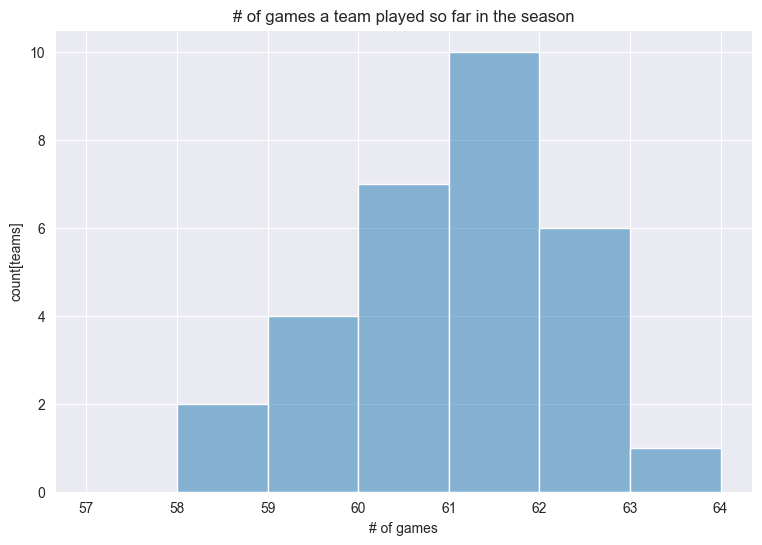

In [19]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(total_games, alpha = 0.5, bins = np.arange(min(total_games) - 1, max(total_games) + 1))
ax.set(title = "# of games a team played so far in the season", xlabel = '# of games', ylabel='count[teams]')
plt.legend([],[], frameon = False)
plt.show(fig);

__Histogram of number of players per game (for a single group) in the current season (2022-2023) so far__

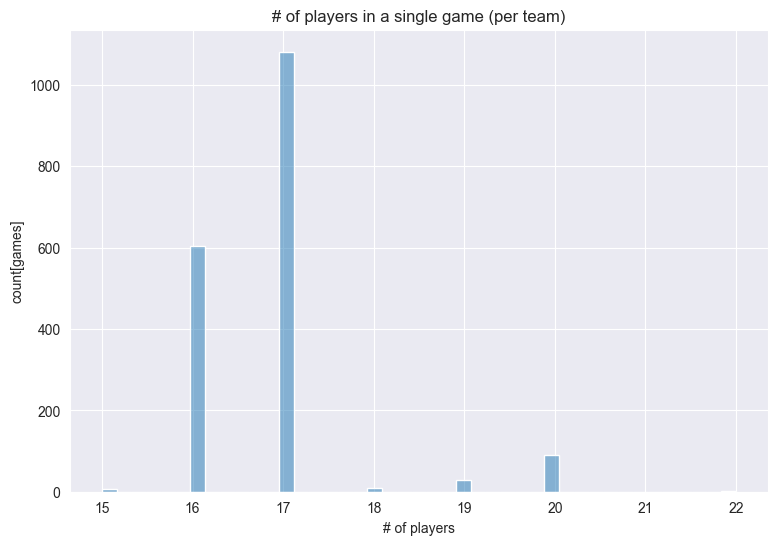

In [20]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_line_up.groupby(['GameID', 'TeamID']).count().to_numpy(), alpha = 0.5)
ax.set(title = "# of players in a single game (per team)", xlabel = '# of players', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Field goals

__Histogram of field goals made out of field goals attempted in a single game per group in the current season (2022-2023) so far__

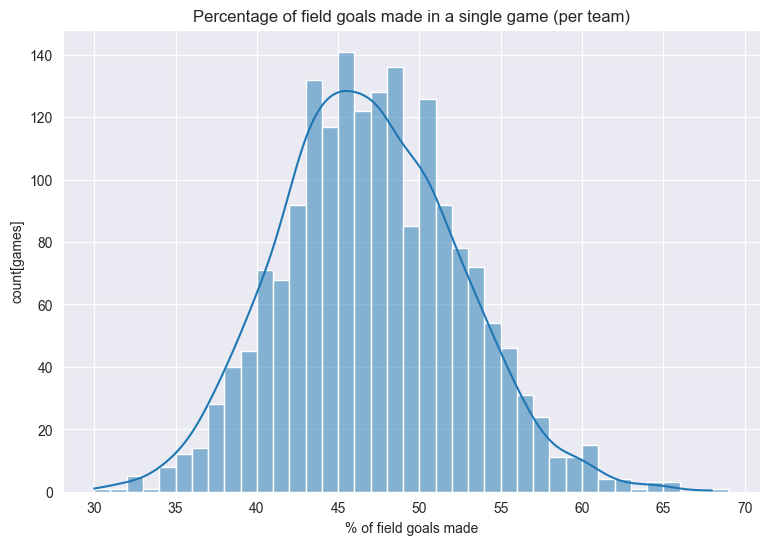

In [21]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['FGPER'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(30, 70))
ax.set(title = "Percentage of field goals made in a single game (per team)", xlabel = '% of field goals made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [22]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'FGPER']].groupby(['TeamID']).mean().nlargest(3, columns='FGPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'FG%',  f'{team.values[0]:.2f}%'))


Team with highest FG% is Denver Nuggets - 50.30%
Team with 2nd highest FG% is Brooklyn Nets - 49.75%
Team with 3rd highest FG% is Chicago Bulls - 48.93%


### Three points field goals

__Histogram of three point field goal made out of attempted in a single game per group in the current season (2022-2023) so far__

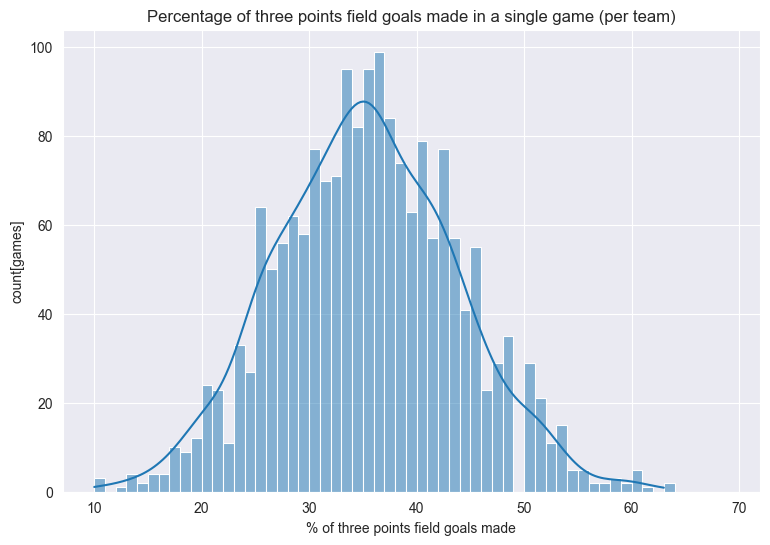

In [23]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['ThreePPER'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(10, 70))
ax.set(title = "Percentage of three points field goals made in a single game (per team)", xlabel = '% of three points field goals made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [24]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'ThreePPER']].groupby(['TeamID']).mean().nlargest(3, columns='ThreePPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], '3FG%',  f'{team.values[0]:.2f}%'))


Team with highest 3FG% is Denver Nuggets - 38.54%
Team with 2nd highest 3FG% is Brooklyn Nets - 38.17%
Team with 3rd highest 3FG% is Golden State Warriors - 37.62%


In [25]:
grouped = game_player_score.to_pandas().loc[:, ['PlayerID', 'ThreePA', 'ThreePPER']].groupby('PlayerID')
three_best_players = grouped.filter(lambda x: x['ThreePA'].count() > 10).loc[:, ['PlayerID', 'ThreePPER']].groupby('PlayerID').mean().nlargest(3, columns='ThreePPER')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], '3FG%', f'{player.values[0]:.2f}%'))

Player with highest 3FG% is Buddy Hield - 41.92%
Player with 2nd highest 3FG% is Damion Lee - 40.85%
Player with 3rd highest 3FG% is Patrick Williams - 39.51%


__Histogram of three point field goal made out of field goal made in a single game per group in the current season (2022-2023) so far__

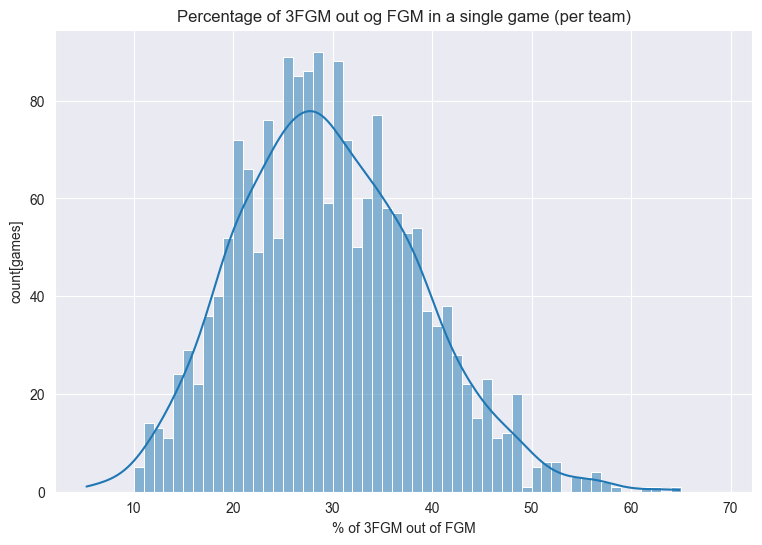

In [26]:
game_team_score['3FGM_to_FGM'] = game_team_score['ThreePM'] * 100 /game_team_score['FGM']
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['3FGM_to_FGM'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(10, 70))
ax.set(title = "Percentage of 3FGM out og FGM in a single game (per team)", xlabel = '% of 3FGM out of FGM', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [27]:
three_best_teams = game_team_score.loc[:, ['TeamID', '3FGM_to_FGM']].groupby(['TeamID']).mean().nlargest(3, columns='3FGM_to_FGM')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'precentage of 3FGM out of FGM', f'{team.values[0]:.2f}%'))

Team with highest precentage of 3FGM out of FGM is Dallas Mavericks - 38.21%
Team with 2nd highest precentage of 3FGM out of FGM is Golden State Warriors - 38.21%
Team with 3rd highest precentage of 3FGM out of FGM is Boston Celtics - 38.16%


### Free throws

__Histogram of free throws made out of free throws attempted in a single game per group in the current season (2022-2023) so far__

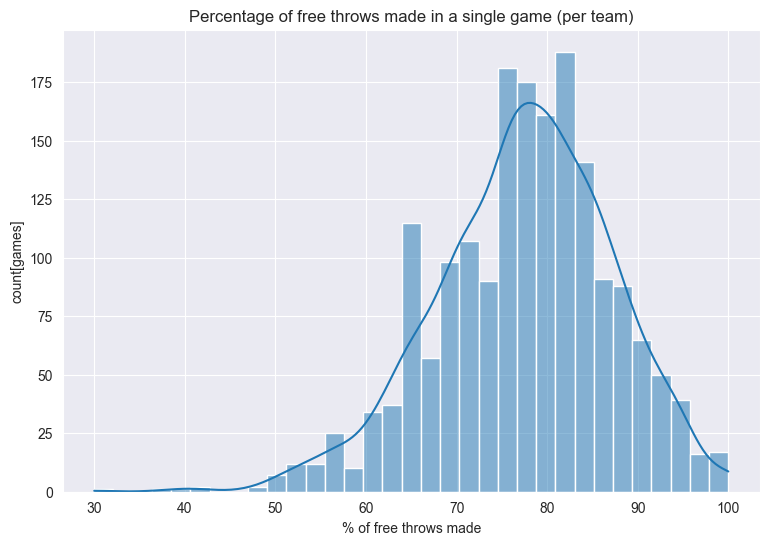

In [28]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['FTPER'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "Percentage of free throws made in a single game (per team)", xlabel = '% of free throws made', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [29]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'FTPER']].groupby(['TeamID']).mean().nlargest(3, columns='FTPER')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'FT%', f'{team.values[0]:.2f}%'))

Team with highest FT% is Boston Celtics - 82.43%
Team with 2nd highest FT% is Miami Heat - 82.05%
Team with 3rd highest FT% is Philadelphia 76ers - 81.93%


### Rebounds

__Histogram of total rebounds in a single game per group in the current season (2022-2023) so far__

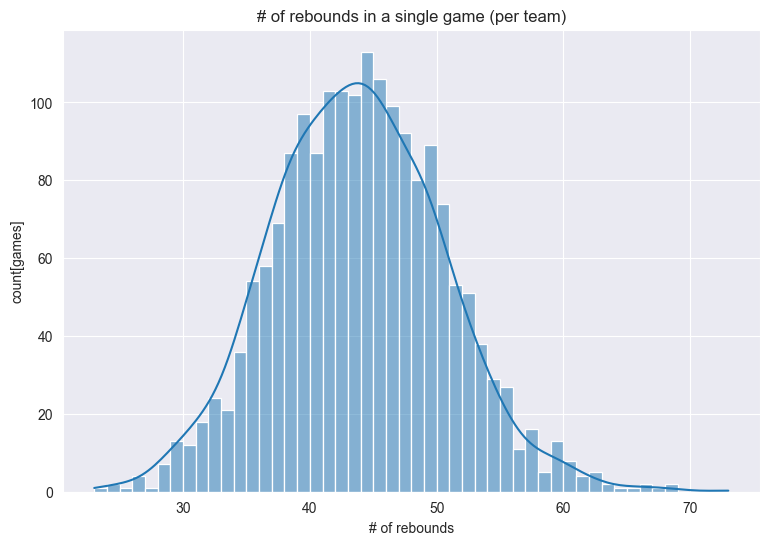

In [30]:
game_team_score['REB'] = game_team_score['OREB'] + game_team_score['DREB']
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['REB'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(23, 70))
ax.set(title = "# of rebounds in a single game (per team)", xlabel = '# of rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [31]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'REB']].groupby(['TeamID']).mean().nlargest(3, columns='REB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of rebounds is Milwaukee Bucks - 48.72
Team with 2nd highest avg number of rebounds is Memphis Grizzlies - 47.92
Team with 3rd highest avg number of rebounds is New York Knicks - 47.11


In [32]:
game_player_score['REB'] = game_player_score['OREB'] + game_player_score['DREB']
three_best_players = game_player_score.loc[:, ['PlayerID', 'REB']].groupby(['PlayerID']).mean().nlargest(3, columns='REB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of rebounds is Domantas Sabonis - 11.53
Player with 2nd highest avg number of rebounds is Nikola Vucevic - 11.25
Player with 3rd highest avg number of rebounds is Julius Randle - 10.59


__Histogram of offensive rebounds in a single game per group in the current season (2022-2023) so far__

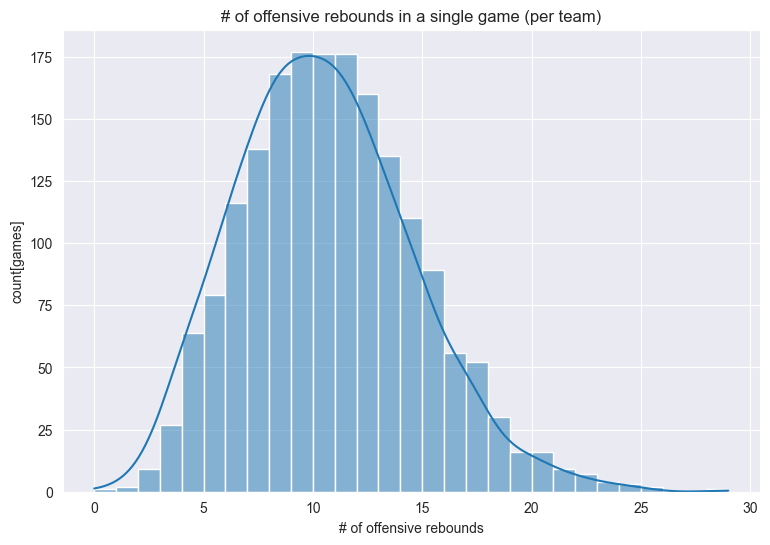

In [33]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['OREB'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(0, 30))
ax.set(title = "# of offensive rebounds in a single game (per team)", xlabel = '# of offensive rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [34]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'OREB']].groupby(['TeamID']).mean().nlargest(3, columns='OREB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of offensive rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of offensive rebounds is Houston Rockets - 13.15
Team with 2nd highest avg number of offensive rebounds is New York Knicks - 12.93
Team with 3rd highest avg number of offensive rebounds is Memphis Grizzlies - 12.90


In [35]:
three_best_players = game_player_score.loc[:, ['PlayerID', 'OREB']].groupby(['PlayerID']).mean().nlargest(3, columns='OREB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of offensive rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of offensive rebounds is Steven Adams - 3.83
Player with 2nd highest avg number of offensive rebounds is Mason Plumlee - 3.13
Player with 3rd highest avg number of offensive rebounds is Ivica Zubac - 3.08


__Histogram of defensive rebounds in a single game per group in the current season (2022-2023) so far__

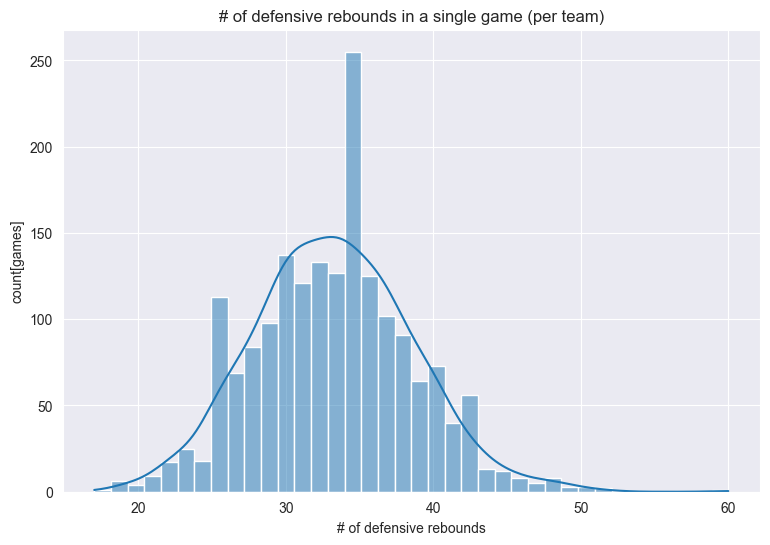

In [36]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['DREB'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "# of defensive rebounds in a single game (per team)", xlabel = '# of defensive rebounds', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [37]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'DREB']].groupby(['TeamID']).mean().nlargest(3, columns='DREB')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg number of defensive rebounds', f'{team.values[0]:.2f}'))

Team with highest avg number of defensive rebounds is Milwaukee Bucks - 36.98
Team with 2nd highest avg number of defensive rebounds is Boston Celtics - 35.88
Team with 3rd highest avg number of defensive rebounds is Los Angeles Lakers - 35.71


In [38]:
three_best_players = game_player_score.loc[:, ['PlayerID', 'DREB']].groupby(['PlayerID']).mean().nlargest(3, columns='DREB')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'avg number of defensive rebounds', f'{player.values[0]:.2f}'))

Player with highest avg number of defensive rebounds is Nikola Vucevic - 9.15
Player with 2nd highest avg number of defensive rebounds is Domantas Sabonis - 8.78
Player with 3rd highest avg number of defensive rebounds is Julius Randle - 8.51


### Asists

__Histogram of assits in a single game per group in the current season (2022-2023) so far__

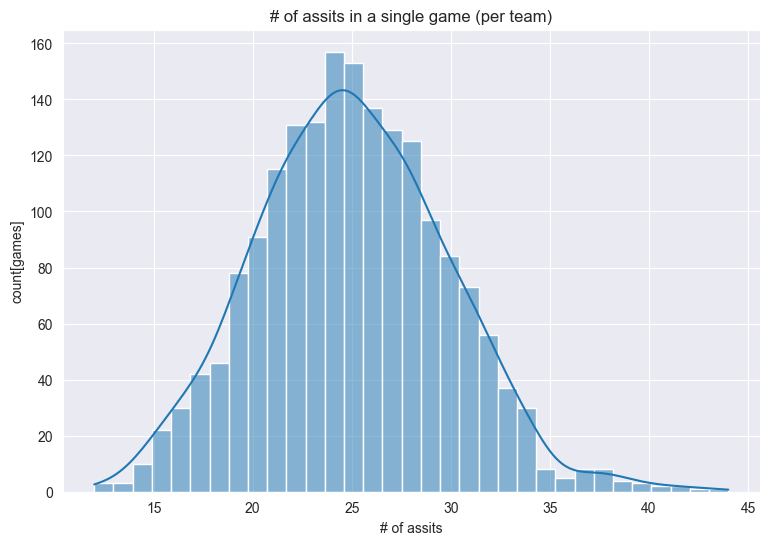

In [39]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['AST'].to_numpy(), alpha = 0.5, kde = True)
ax.set(title = "# of assits in a single game (per team)", xlabel = '# of assits', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [40]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'AST']].groupby(['TeamID']).mean().nlargest(3, columns='AST')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg of assits', f'{team.values[0]:.2f}'))

Team with highest avg of assits is Golden State Warriors - 29.48
Team with 2nd highest avg of assits is Denver Nuggets - 28.54
Team with 3rd highest avg of assits is Sacramento Kings - 27.03


### Blocks

__Histogram of blocks in a single game per group in the current season (2022-2023) so far__

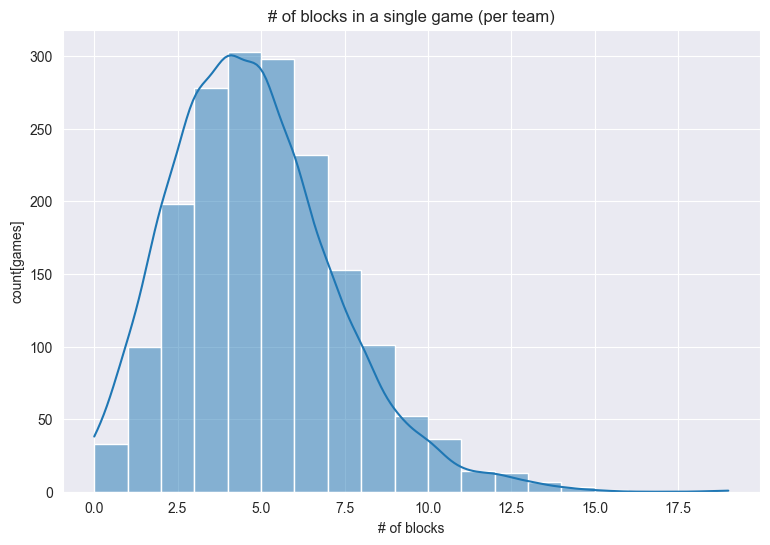

In [41]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['BLK'].to_numpy(), alpha = 0.5, kde = True, bins = np.arange(0, 18))
ax.set(title = "# of blocks in a single game (per team)", xlabel = '# of blocks', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

In [42]:
three_best_teams = game_team_score.loc[:, ['TeamID', 'BLK']].groupby(['TeamID']).mean().nlargest(3, columns='BLK')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[index], 'avg of blocks', f'{team.values[0]:.2f}'))

Team with highest avg of blocks is Brooklyn Nets - 6.54
Team with 2nd highest avg of blocks is Indiana Pacers - 6.00
Team with 3rd highest avg of blocks is Memphis Grizzlies - 5.92


### Steals

__Histogram of steals in a single game per group in the current season (2022-2023) so far__

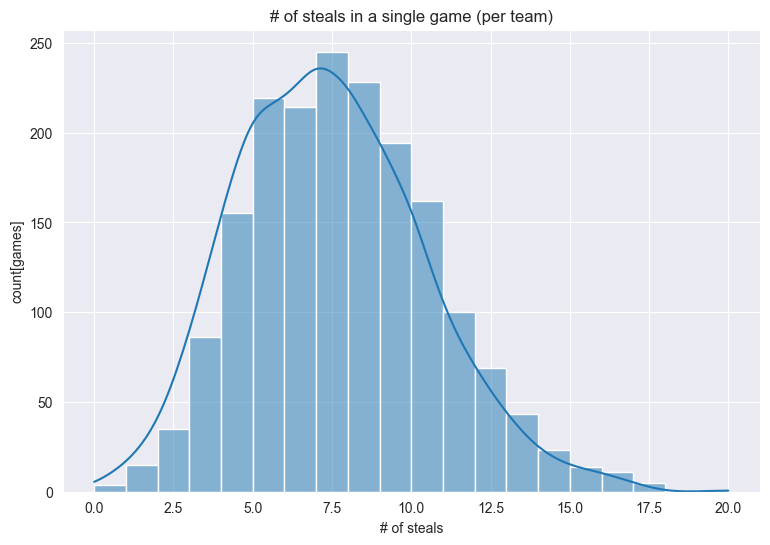

In [43]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['STL'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "# of steals in a single game (per team)", xlabel = '# of steals', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Turnovers

__Histogram of turnovers in a single game per group in the current season (2022-2023) so far__

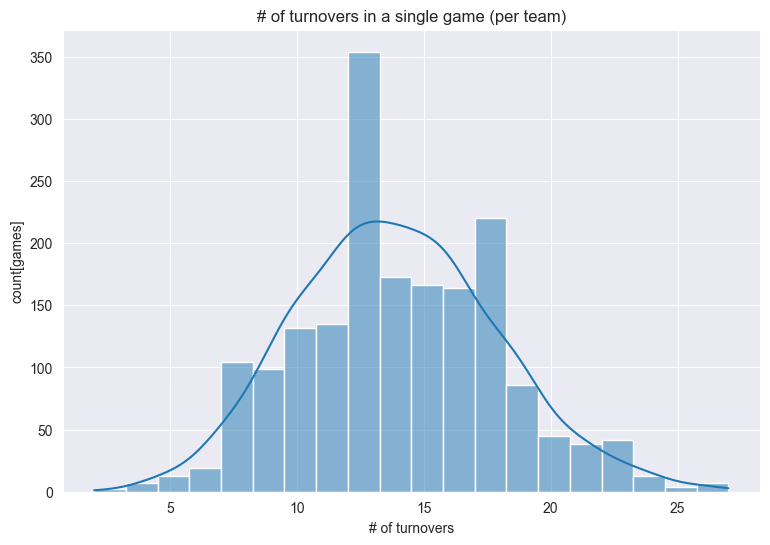

In [44]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(game_team_score['TournOvers'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "# of turnovers in a single game (per team)", xlabel = '# of turnovers', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

### Teams recovery

In [45]:
teams_recovery_3rd= {teamID: 0 for teamID in teams_dict.keys()}    
teams_recovery_half= {teamID: 0 for teamID in teams_dict.keys()}    

for i, row in finished_games.iterrows():        
    visitor_team_pts_3rd = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'ScoreQThree'].to_numpy()[0]
    home_team_pts_3rd = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'ScoreQThree'].to_numpy()[0]

    visitor_team_pts_half = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'ScoreQTwo'].to_numpy()[0]
    home_team_pts_half = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'ScoreQTwo'].to_numpy()[0]

    visitor_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'PTS'].to_numpy()[0]
    home_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'PTS'].to_numpy()[0]
    
    if (visitor_team_pts_3rd > home_team_pts_3rd) and (home_team_pts > visitor_team_pts):
       teams_recovery_3rd[row['HomeTeamID']] += 1

    if (visitor_team_pts_half > home_team_pts_half) and (home_team_pts > visitor_team_pts):
       teams_recovery_half[row['HomeTeamID']] += 1

    if (home_team_pts_3rd > visitor_team_pts_3rd) and (visitor_team_pts > home_team_pts):
       teams_recovery_3rd[row['VisitorTeamID']] += 1

    if (home_team_pts_half > visitor_team_pts_half) and (visitor_team_pts_half > home_team_pts_half):
        teams_recovery_half[row['VisitorTeamID']] += 1

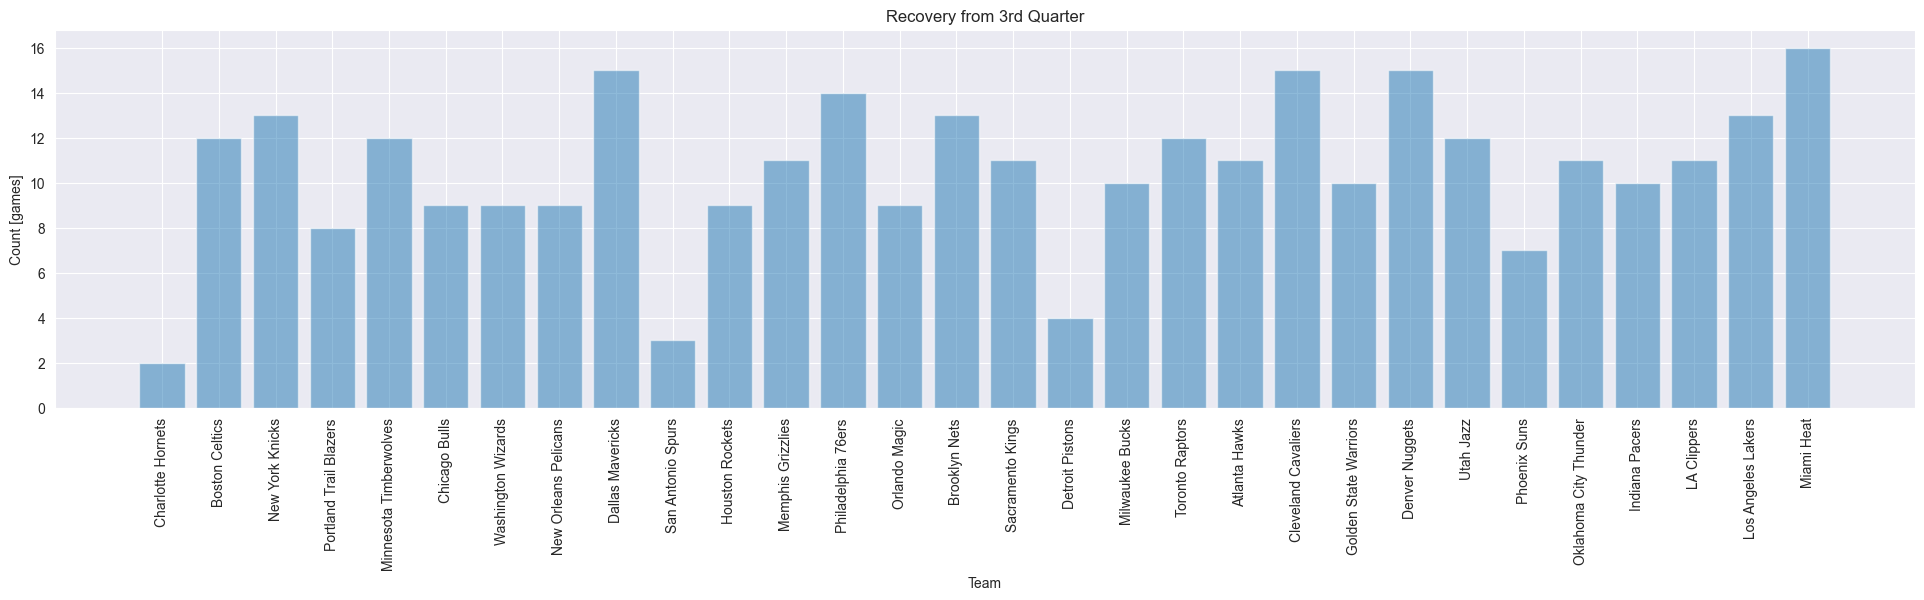

In [46]:
keys = [teams_dict[key] for key in teams_recovery_3rd.keys()]
values = teams_recovery_3rd.values()
fig, ax = plt.subplots(num = figure_count, figsize = (24,  6))
figure_count += 1
plt.subplots_adjust(right=0.9, top=0.9, bottom=0.27)
ax.bar(keys, values, alpha = 0.5)
ax.set_xticks(range(len(keys)), keys, rotation=90)
ax.set_xlabel('Team')
ax.set_ylabel('Count [games]')
ax.set_title('Recovery from 3rd Quarter')
plt.show(fig);

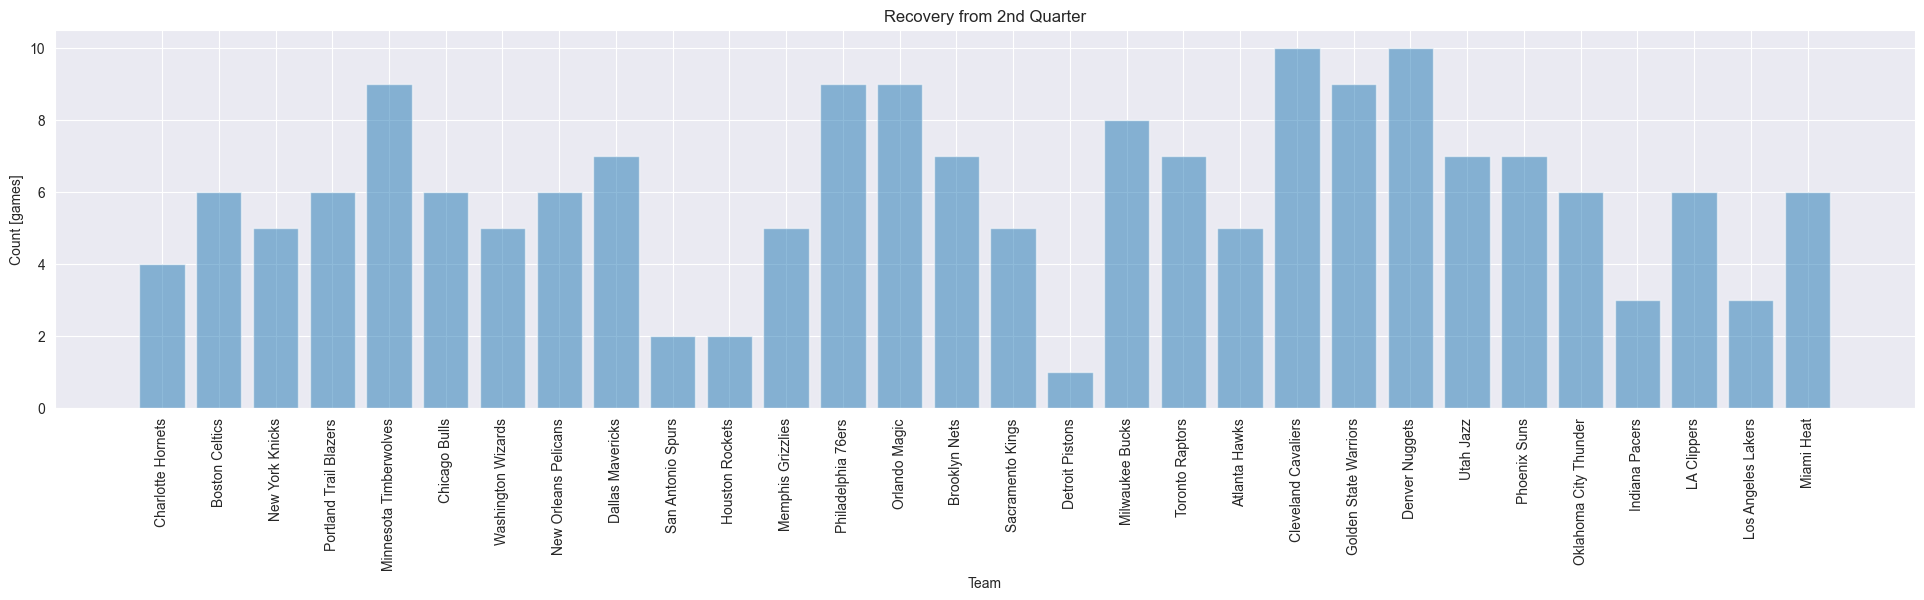

In [47]:
keys = [teams_dict[key] for key in teams_recovery_half.keys()]
values = teams_recovery_half.values()
fig, ax = plt.subplots(num = figure_count, figsize = (24,  6))
figure_count += 1
plt.subplots_adjust(right=0.9, top=0.9, bottom=0.27)
ax.bar(keys, values, alpha = 0.5)
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel('Team')
ax.set_ylabel('Count [games]')
ax.set_title('Recovery from 2nd Quarter')
plt.show(fig);

### Teams "Power Ranking"

In [48]:
game_team_score_grouped = game_team_score.groupby(['TeamID']).mean().reset_index()

In [49]:
teams_wins = {teamID: 0 for teamID in teams_dict.keys()}    
teams_losses = {teamID: 0 for teamID in teams_dict.keys()}


for i, row in finished_games.iterrows():        
    visitor_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'PTS'].to_numpy()[0]
    home_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'PTS'].to_numpy()[0]
    
    if visitor_team_pts > home_team_pts:
        teams_wins[row['VisitorTeamID']] += 1
        teams_losses[row['HomeTeamID']] += 1
        # game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'win'] = 1
        # game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'win'] = 0

    else:
        teams_wins[row['HomeTeamID']] += 1
        teams_losses[row['VisitorTeamID']] += 1
        # game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'win'] = 0
        # game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'win'] = 1

for key, value in teams_wins.items():
    game_team_score_grouped.loc[game_team_score_grouped['TeamID'] == key, 'wins'] = value

In [50]:
game_team_score_grouped['TeamScore'] = 0.2 * game_team_score_grouped['wins'] + \
                                        0.2 * game_team_score_grouped['PTS'] + \
                                        0.2 * game_team_score_grouped['AST'] + \
                                        0.1 * game_team_score_grouped['STL'] + \
                                        0.1 * game_team_score_grouped['BLK'] + \
                                        0.2 * game_team_score_grouped['REB']

In [51]:
three_best_teams = game_team_score_grouped.nlargest(3, columns='TeamScore')
for i, (index, team) in enumerate(three_best_teams.iterrows()):
    print(index_to_strings(i, teams_dict[team['TeamID']], 'overall score', ''))

23/02/15 16:07:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Team with highest overall score is Boston Celtics - 
Team with 2nd highest overall score is Denver Nuggets - 
Team with 3rd highest overall score is Memphis Grizzlies - 


### Players "Power Ranking"

In [52]:
game_player_score_grouped = game_player_score.groupby(['PlayerID']).mean()
game_player_score_grouped['PlayerScore'] = 0.4 * game_player_score_grouped['PTS'] + \
                                            0.2 * game_player_score_grouped['AST'] + \
                                            0.1 * game_player_score_grouped['STL'] + \
                                            0.1 * game_player_score_grouped['BLK'] + \
                                            0.2 * game_player_score_grouped['REB']

In [53]:
three_best_players = game_player_score_grouped.nlargest(3, columns='PlayerScore')
for i, (index, player) in enumerate(three_best_players.iterrows()):
    print(index_to_strings_players(i, players_dict[index], 'overall score', ''))

Player with highest overall score is Jayson Tatum - 
Player with 2nd highest overall score is Luka Doncic - 
Player with 3rd highest overall score is Julius Randle - 


## Team level analysis
### seleceted team - Phoenix Suns

In [54]:
# Change selected team here
selected_team_ID = teams_names_dict['Phoenix Suns']

In [55]:
selected_team_games = finished_games.loc[(finished_games['HomeTeamID'] == selected_team_ID) | (finished_games['VisitorTeamID'] == selected_team_ID), :]

for i, row in selected_team_games.iterrows():
    if row['HomeTeamID'] == selected_team_ID:
        home = True
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'home'] = True
    else:
        home = False
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'home'] = False

    selected_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'PTS'].to_numpy()[0]

    # Fill the df with stats from the game
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'PTS'] = selected_team_pts
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'FGPER'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'FGPER'].to_numpy()[0]
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'ThreePPER'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), 'ThreePPER'].to_numpy()[0]
    selected_team_games.loc[selected_team_games['ID'] == row['ID'], '3FGM_to_FGM'] = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == selected_team_ID), '3FGM_to_FGM'].to_numpy()[0]

    if home:
        other_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['VisitorTeamID']), 'PTS'].to_numpy()[0]
    else:
        other_team_pts = game_team_score.loc[(game_team_score['GameID'] == row['ID']) & (game_team_score['TeamID'] == row['HomeTeamID']), 'PTS'].to_numpy()[0]

    if other_team_pts > selected_team_pts:
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'result'] = 'L'
    else:
        selected_team_games.loc[selected_team_games['ID'] == row['ID'], 'result'] = 'W'


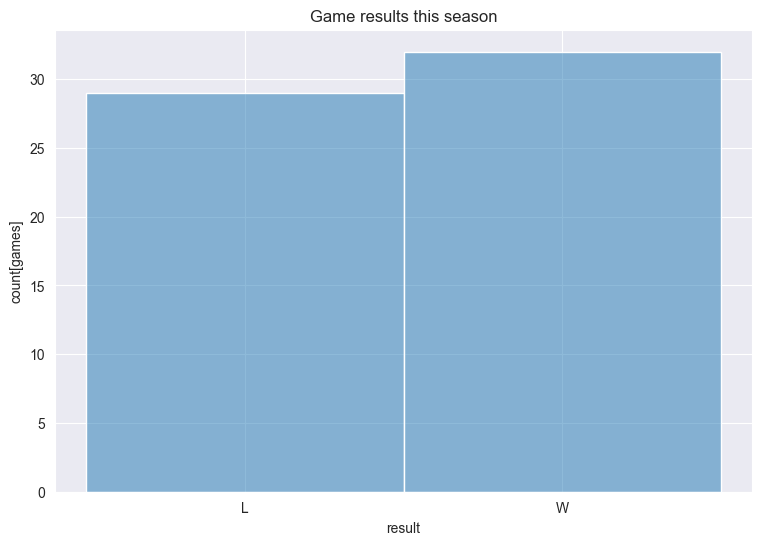

In [56]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_team_games['result'].to_numpy(), alpha = 0.5, bins = [-0.5, 0.5, 1.5])
ax.set(title = "Game results this season", xlabel = 'result', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

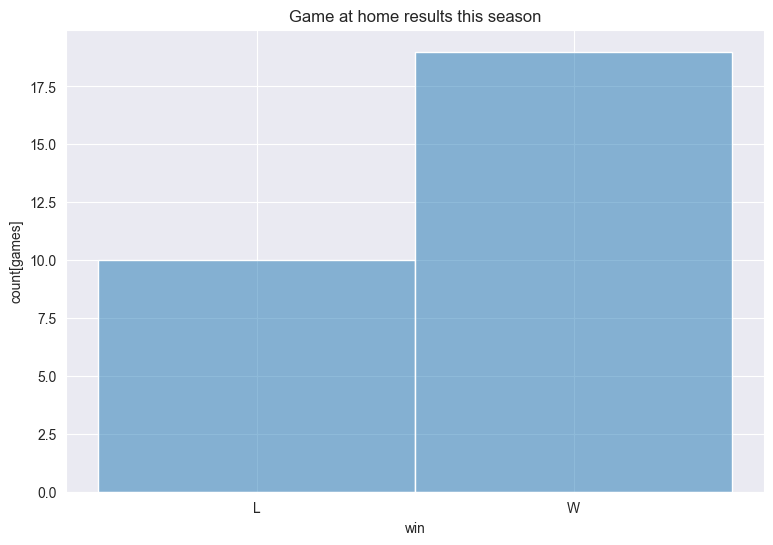

In [57]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_team_games.loc[selected_team_games['home'] == True, 'result'].to_numpy(), alpha = 0.5, bins = [-0.5, 0.5, 1.5])
ax.set(title = "Game at home results this season", xlabel = 'win', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

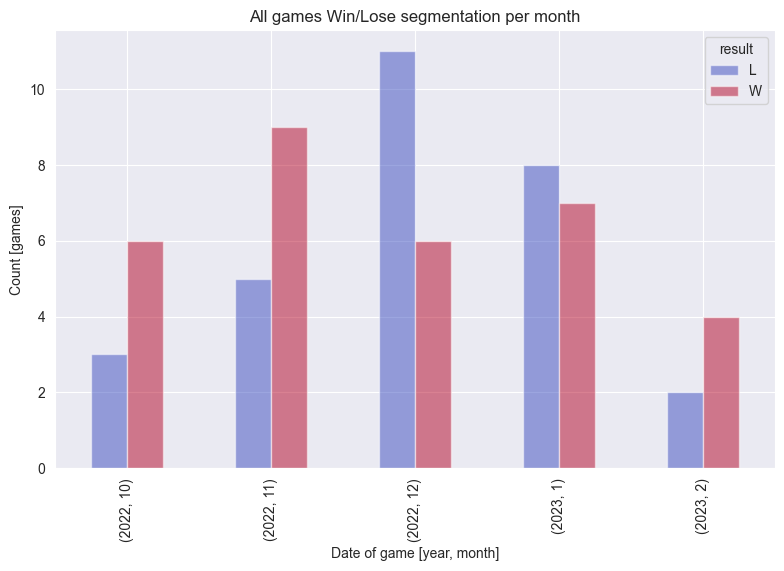

In [58]:
selected_team_games_copy = selected_team_games.to_pandas().set_index('Date')

line_plot = selected_team_games_copy.home

line_plot2 = selected_team_games_copy.result

bar_plot = line_plot.groupby([line_plot.index.year, line_plot.index.month, line_plot2]).count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('All games Win/Lose segmentation per month')
plt.show(fig);

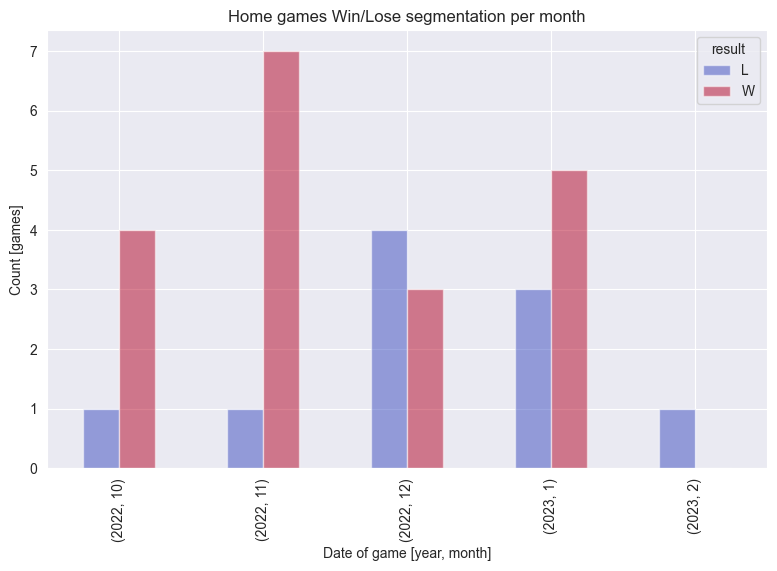

In [59]:
home_games = selected_team_games['home'] == True
selected_team_games_at_home_copy = selected_team_games.loc[home_games, :].to_pandas().set_index('Date')

line_plot = selected_team_games_at_home_copy.home

line_plot2 = selected_team_games_at_home_copy.result

bar_plot = line_plot.groupby([line_plot.index.year, line_plot.index.month, line_plot2]).count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('Home games Win/Lose segmentation per month')
plt.show(fig);

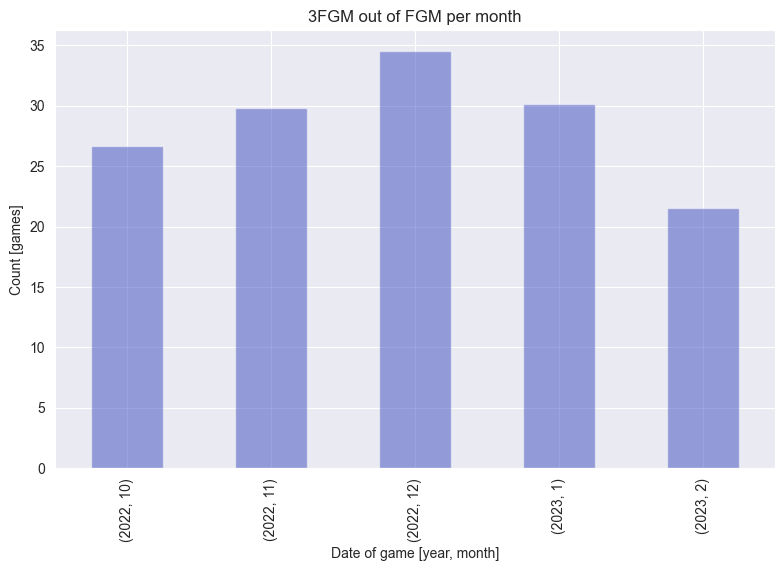

In [60]:
line_plot = selected_team_games_copy.home

bar_plot = selected_team_games_copy['3FGM_to_FGM'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('3FGM out of FGM per month')
plt.show(fig);

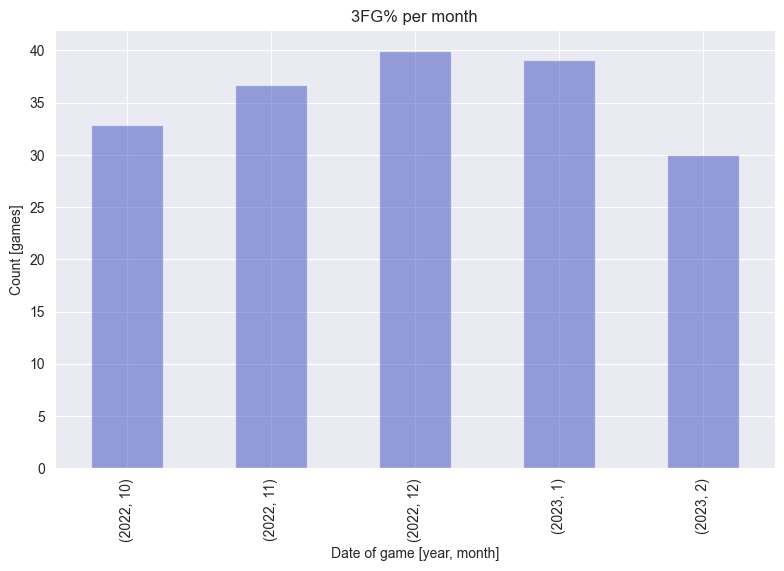

In [61]:
bar_plot = selected_team_games_copy['ThreePPER'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('Count [games]')
ax.set_title('3FG% per month')
plt.show(fig);

In [62]:
grouped = pd.DataFrame(game_line_up.loc[game_line_up['TeamID'] == selected_team_ID, ['GameID', 'PlayerID']].to_pandas().groupby('GameID')['PlayerID'].apply(list))
for gameID in grouped.index:
    grouped.loc[gameID, 'result'] = selected_team_games.loc[selected_team_games['ID'] == gameID, 'result'].to_numpy()[0]

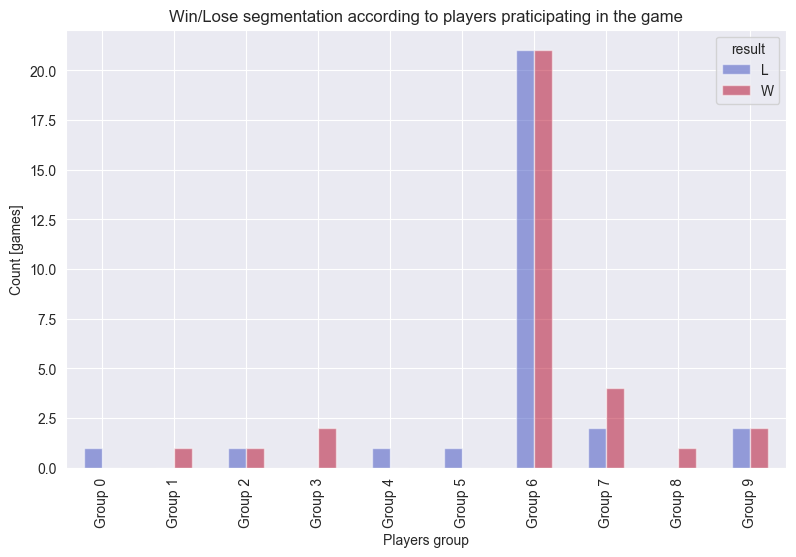

In [63]:
grouped['PlayerID'] = grouped.PlayerID.apply(tuple)
bar_plot = grouped.reset_index().groupby(['PlayerID', 'result'])['GameID'].count().unstack()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Players group')
ax.set_ylabel('Count [games]')
ax.set_title('Win/Lose segmentation according to players praticipating in the game')
ax.set_xticklabels([f'Group {i}' for i in range(len(ax.get_xticks()))])
plt.show(fig);

In [64]:
for i, group_players in enumerate(bar_plot.index):
    print(f'Players in group {i}:')
    print([players_dict[player] for player in group_players])

Players in group 0:
['Torrey Craig', 'T.J. Warren', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre Ayton', 'Kevin Durant', 'Saben Lee']
Players in group 1:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'T.J. Warren', 'Deandre Ayton', 'Kevin Durant', 'Saben Lee', 'Darius Bazley']
Players in group 2:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Saric', 'Deandre Ayton', 'Cameron Johnson', 'Mikal Bridges', 'Saben Lee', 'Jae Crowder']
Players in group 3:
['Torrey Craig', 'Devin Booker', 'Josh Okogie', 'Chris Paul', 'Saben Lee', 'Damion Lee', 'Jock Landale', 'Ish Wainright', 'Landry Shamet', 'Cameron Payne', 'Bismack Biyombo', 'Dario Sa

In [65]:
selected_team_players = team_rosters.loc[team_rosters['TeamID'] == selected_team_ID, 'PlayerID'].to_numpy()
selected_team_game_player_score = game_player_score.loc[game_player_score['PlayerID'].isin(selected_team_players), :]

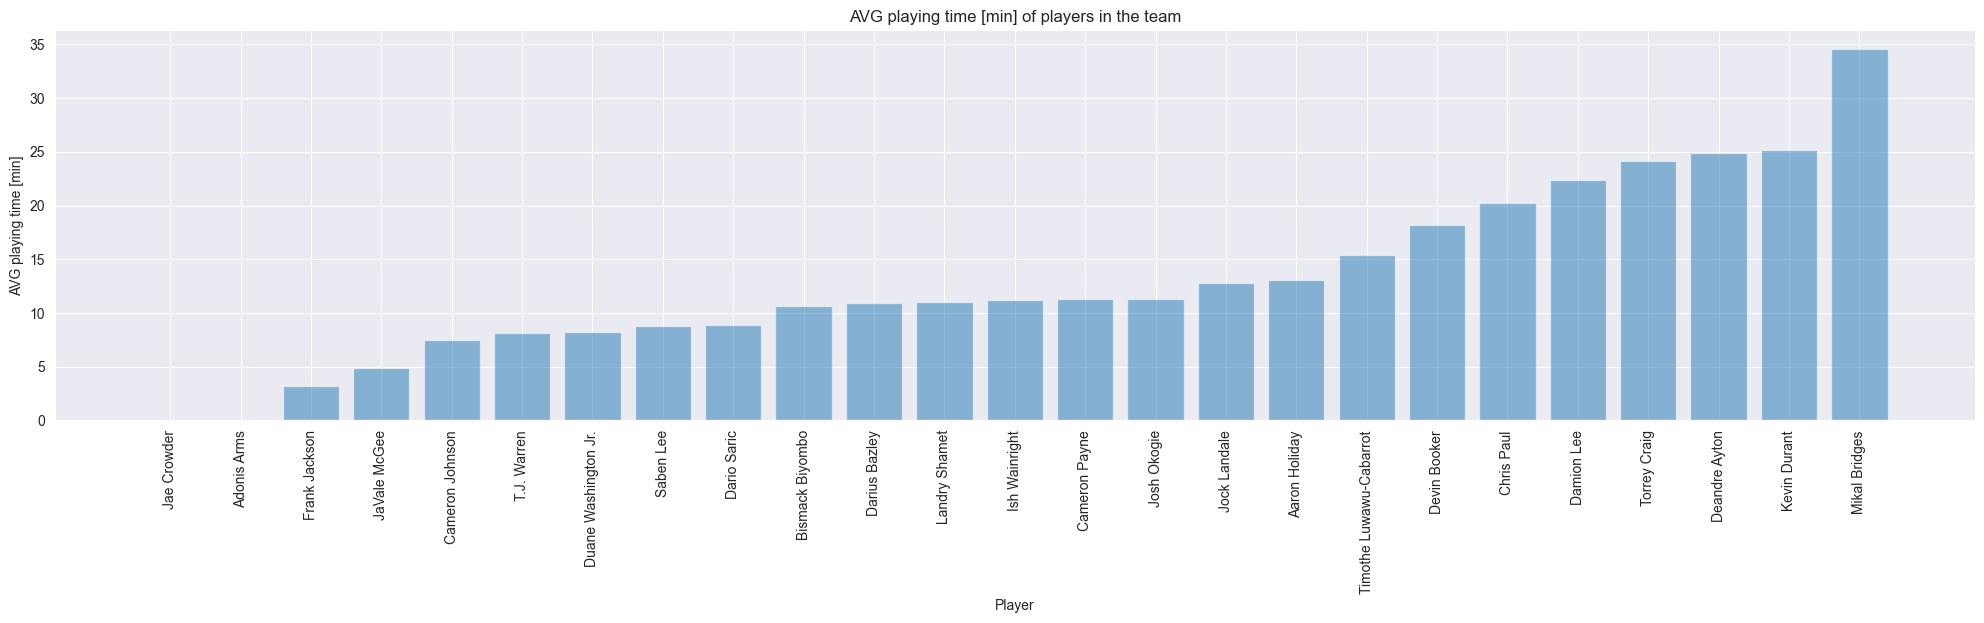

In [66]:
selected_team_game_player_score_grouped = selected_team_game_player_score.groupby('PlayerID').mean().sort_values('PlayTimeInSec')

keys = [players_dict[player] for player in selected_team_game_player_score_grouped.index.to_numpy()]
values = selected_team_game_player_score_grouped['PlayTimeInSec'].to_numpy() / 60

fig, ax = plt.subplots(num = figure_count,  figsize = (24,  6))
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
ax.bar(keys, values, alpha = 0.5, )
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel('Player')
ax.set_ylabel('AVG playing time [min]')
ax.set_title('AVG playing time [min] of players in the team')
plt.show(fig);

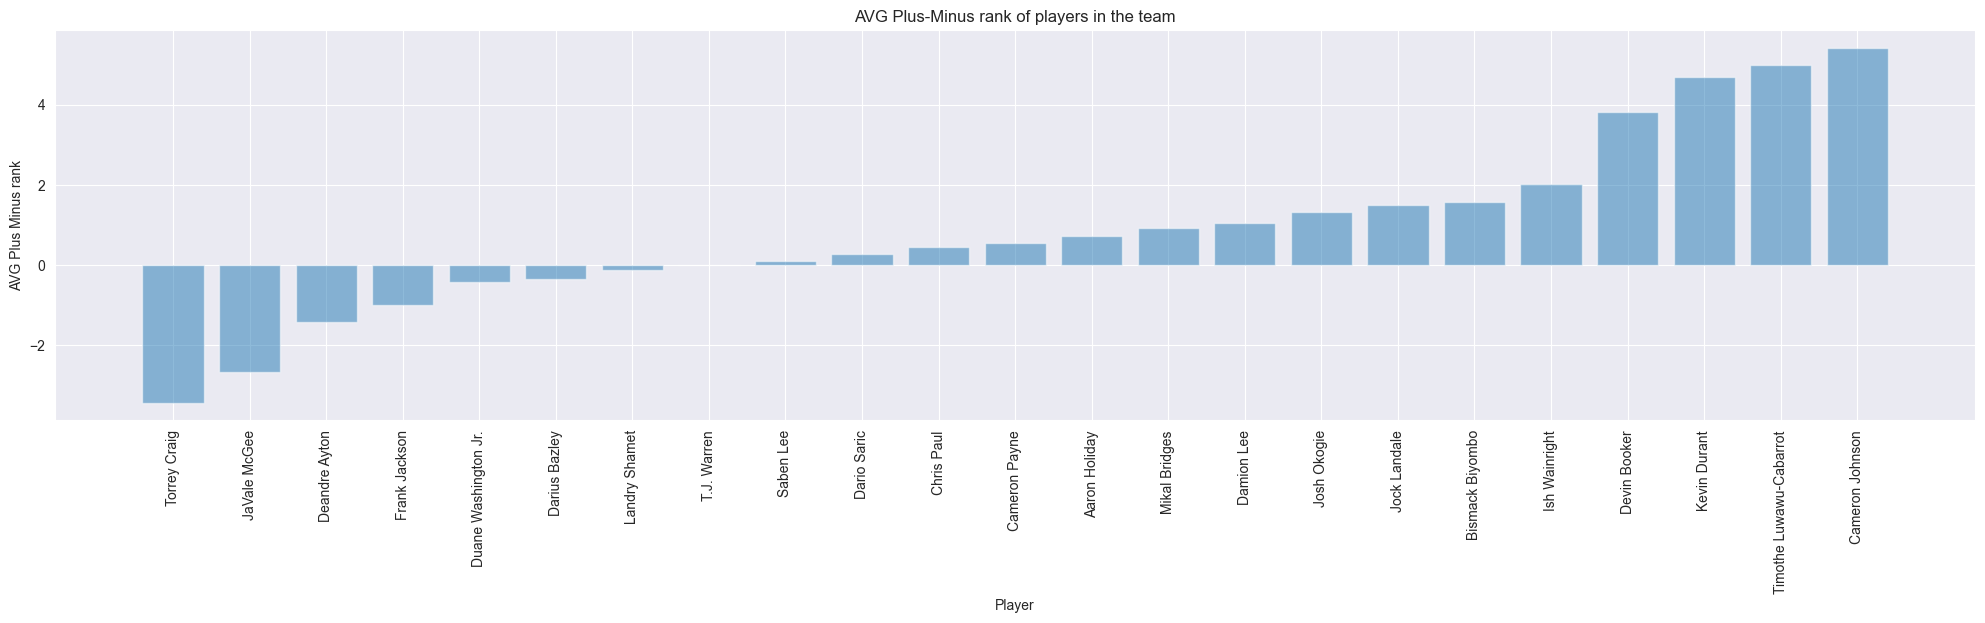

In [67]:
selected_team_game_player_score_grouped = selected_team_game_player_score.loc[game_player_score['PlayTimeInSec'] > 240, :].groupby('PlayerID').mean().sort_values('PlusMinusRank')

keys = [players_dict[player] for player in selected_team_game_player_score_grouped.index.to_numpy()]
values = selected_team_game_player_score_grouped['PlusMinusRank'].to_numpy()

fig, ax = plt.subplots(num = figure_count,  figsize = (24,  6))
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.25)
ax.bar(keys, values, alpha = 0.5)
ax.set_xticks(range(0, len(keys)), keys, rotation=90)
ax.set_xlabel('Player')
ax.set_ylabel('AVG Plus Minus rank')
ax.set_title('AVG Plus-Minus rank of players in the team')
plt.show(fig);

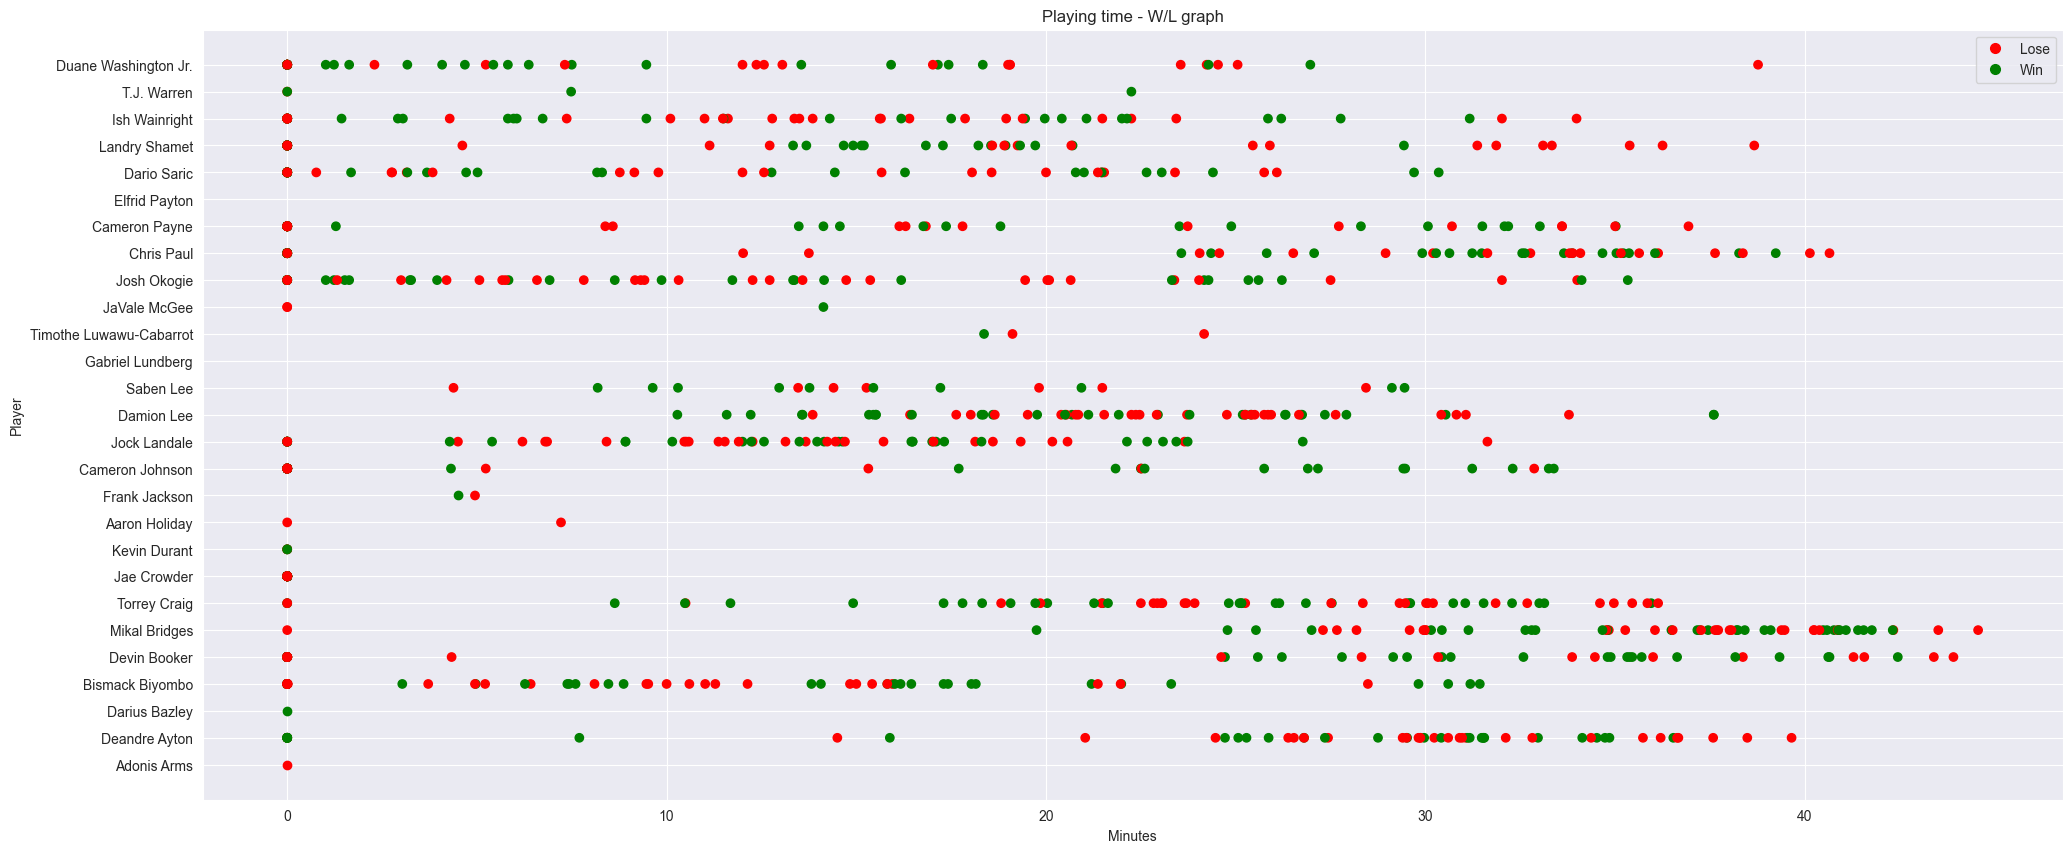

In [68]:
fig, ax = plt.subplots(num = figure_count,  figsize = (24,  10))
figure_count += 1

rows_count = 0
for player_id in selected_team_players:
    player_games = selected_team_game_player_score.loc[selected_team_game_player_score['PlayerID'] == int(player_id), ['PlayerID', 'GameID', 'PlayTimeInSec']]
    player_games['PlayTimeInSec'] = player_games['PlayTimeInSec'] / 60
    player_games = ps.merge(player_games, selected_team_games, left_on=['GameID'], right_on=['ID'])

    scatter = plt.scatter(x = player_games['PlayTimeInSec'].to_numpy(), y = np.ones(player_games.shape[0]) * rows_count, c = ['green' if x == 'W' else 'red' for x in player_games['result'].to_numpy()]) 

    rows_count += 4

ax.set_yticks(range(0, 4 * len(selected_team_players), 4), [players_dict[player] for player in selected_team_players])
ax.set_xlabel('Minutes')
ax.set_ylabel('Player')
ax.set_title('Playing time - W/L graph')

red = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Lose', linewidth=0,)
green = mlines.Line2D([], [], color='green', marker='o',
                          markersize=7, label='Win', linewidth=0,)
ax.legend(handles=[red, green])
plt.show(fig);

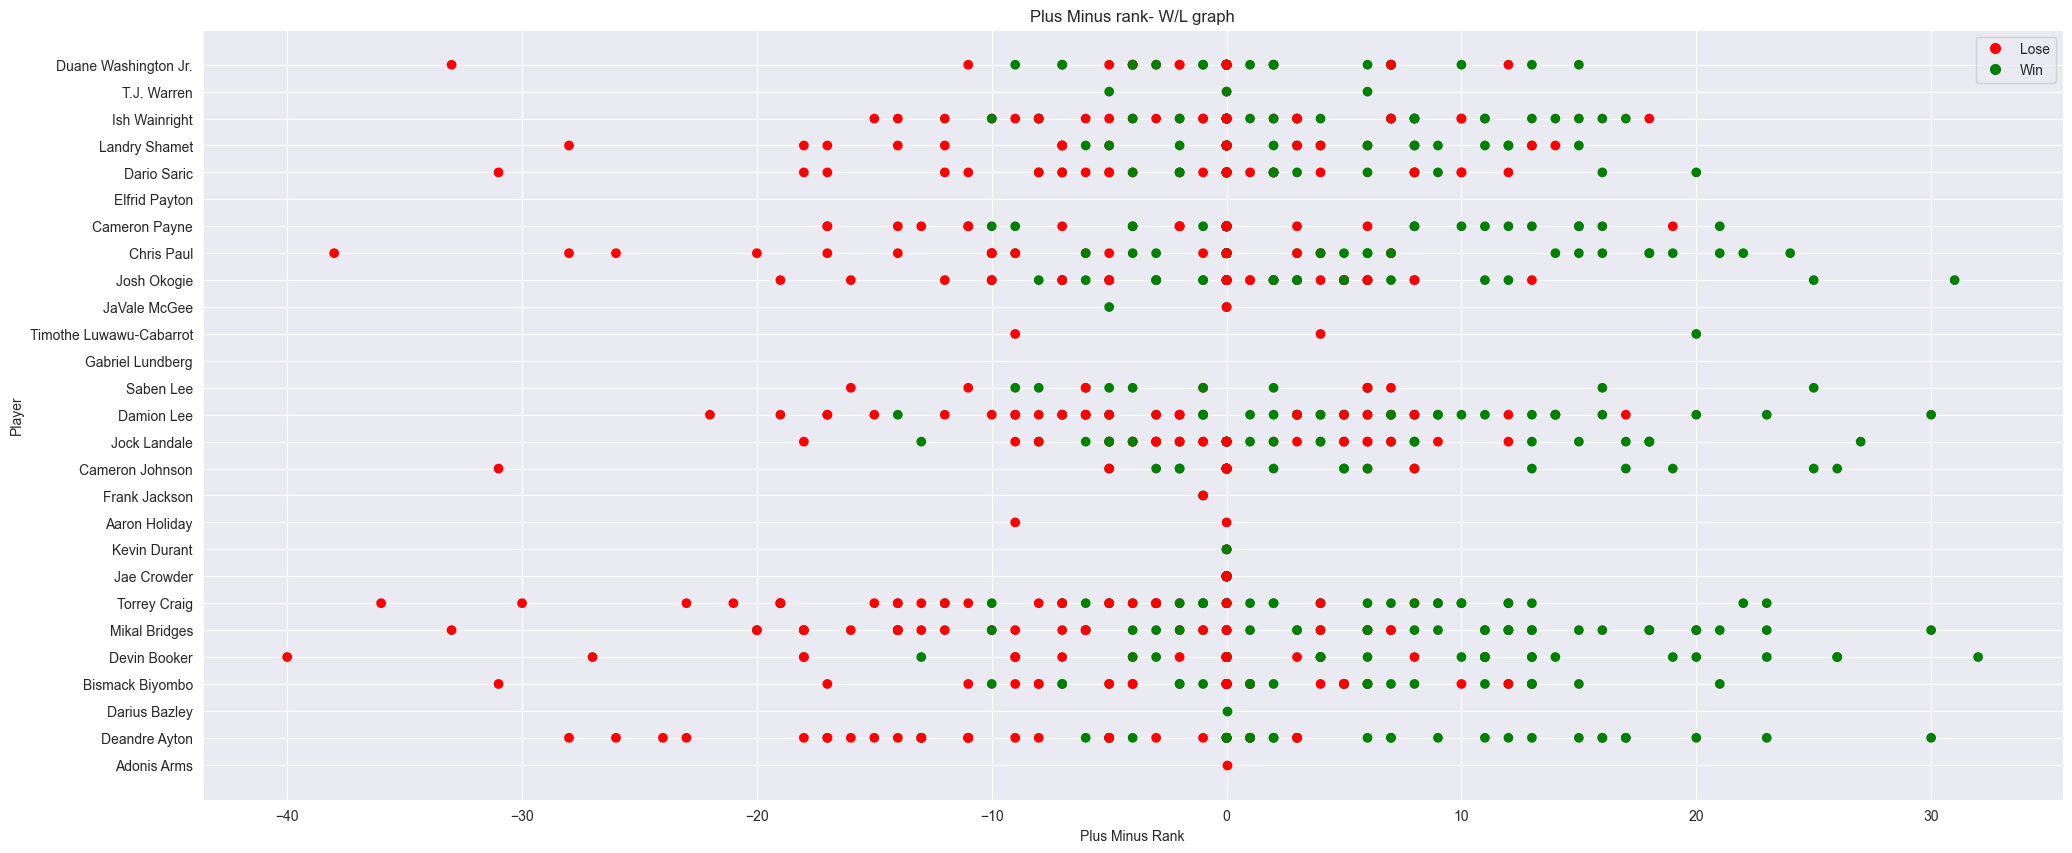

In [69]:
fig, ax = plt.subplots(num = figure_count,  figsize = (24,  10))
figure_count += 1

rows_count = 0
for player_id in selected_team_players:
    player_games = selected_team_game_player_score.loc[selected_team_game_player_score['PlayerID'] == int(player_id), ['PlayerID', 'GameID', 'PlusMinusRank']]
    player_games = ps.merge(player_games, selected_team_games, left_on=['GameID'], right_on=['ID'])

    scatter = plt.scatter(x = player_games['PlusMinusRank'].to_numpy(), y = np.ones(player_games.shape[0]) * rows_count, c = ['green' if x == 'W' else 'red' for x in player_games['result'].to_numpy()]) 

    rows_count += 4

ax.set_yticks(range(0, 4 * len(selected_team_players), 4), [players_dict[player] for player in selected_team_players])
ax.set_xlabel('Plus Minus Rank')
ax.set_ylabel('Player')
ax.set_title('Plus Minus rank- W/L graph')

red = mlines.Line2D([], [], color='red', marker='o',
                          markersize=7, label='Lose', linewidth=0,)
green = mlines.Line2D([], [], color='green', marker='o',
                          markersize=7, label='Win', linewidth=0,)
ax.legend(handles=[red, green])
plt.show(fig);

## Player level analysis
### seleceted player - Deni Avdija

In [70]:
# Change selected player here
selected_player_id = players_names_dict['Deni Avdija']

In [71]:
selected_player_games = game_player_score.loc[game_player_score['PlayerID'] == selected_player_id, :]
selected_player_games['PlayTimeInMin'] = selected_player_games['PlayTimeInSec'] / 60
selected_player_games = ps.merge(selected_player_games, games, left_on=['GameID'], right_on=['ID'])

In [72]:
selected_player_games.columns

Index(['AST', 'BLK', 'DREB', 'FGA', 'FGM', 'FGPER', 'FTA', 'FTM', 'FTPER',
       'GameID', 'OREB', 'PTS', 'PlayTimeInSec', 'PlayerID', 'PlusMinusRank',
       'STL', 'ThreePA', 'ThreePM', 'ThreePPER', 'TournOvers', 'REB',
       'PlayTimeInMin', 'Date', 'HomeTeamID', 'ID', 'LiveStatus',
       'VisitorTeamID'],
      dtype='object')

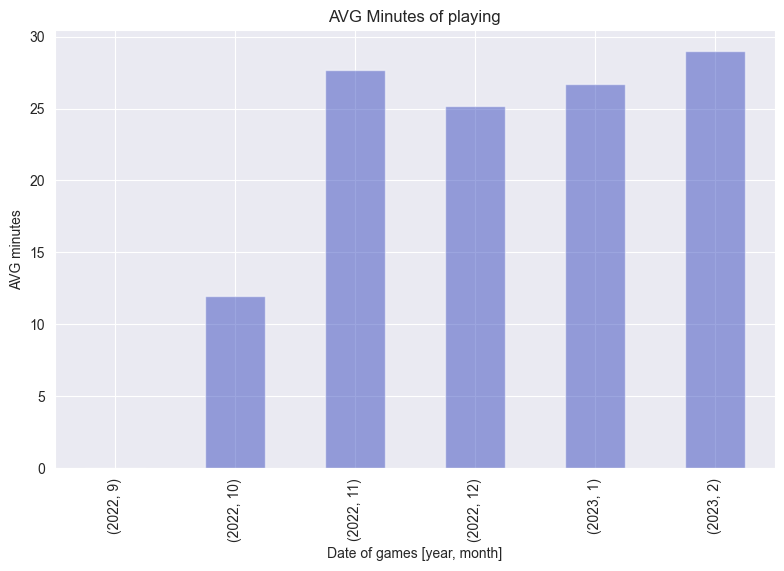

In [73]:
selected_player_games_pd = selected_player_games.to_pandas().set_index('Date')
line_plot = selected_player_games_pd.AST

bar_plot = selected_player_games_pd['PlayTimeInMin'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of games [year, month]')
ax.set_ylabel('AVG minutes')
ax.set_title('AVG Minutes of playing')
plt.show(fig);

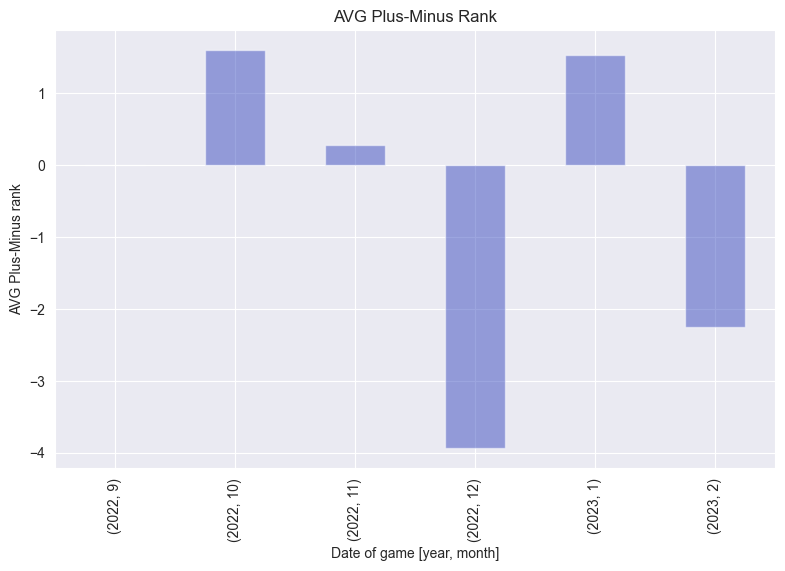

In [74]:
bar_plot = selected_player_games_pd['PlusMinusRank'].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5)
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('AVG Plus-Minus rank')
ax.set_title('AVG Plus-Minus Rank')
plt.show(fig);

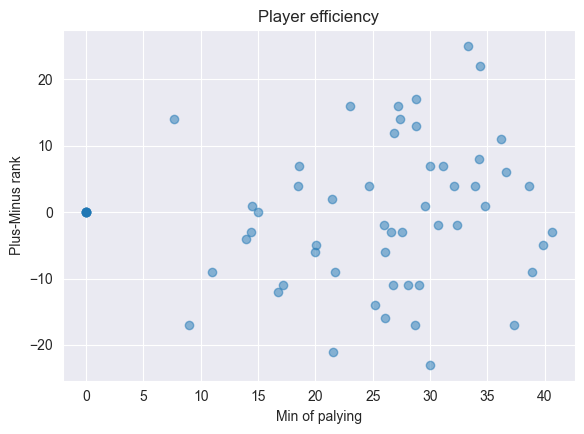

In [75]:
fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
plt.scatter(x = selected_player_games_pd['PlayTimeInMin'], y = selected_player_games_pd['PlusMinusRank'], alpha = 0.5)
ax.set_xlabel('Min of palying')
ax.set_ylabel('Plus-Minus rank')
ax.set_title('Player efficiency')
plt.show(fig);

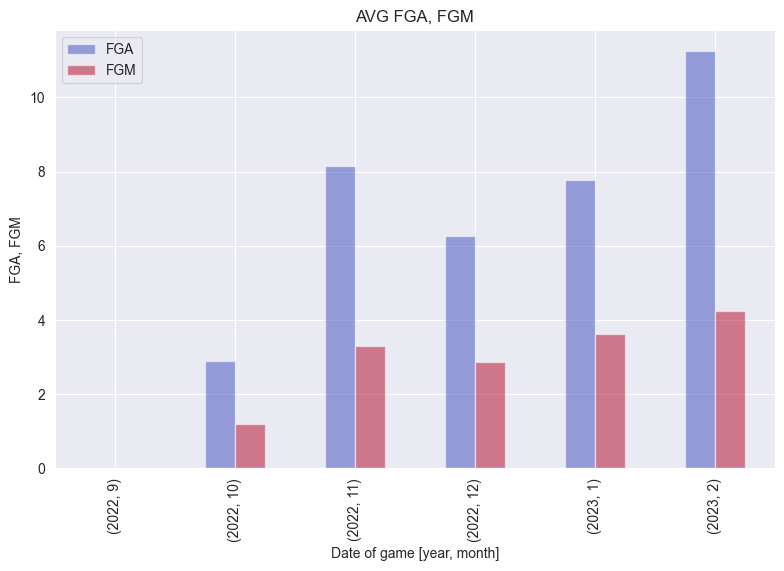

In [76]:
bar_plot = selected_player_games_pd.loc[:, ['FGA', 'FGM']].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5, legend=['3FGA', '3FGM'])
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('FGA, FGM')
ax.set_title('AVG FGA, FGM')
plt.show(fig);

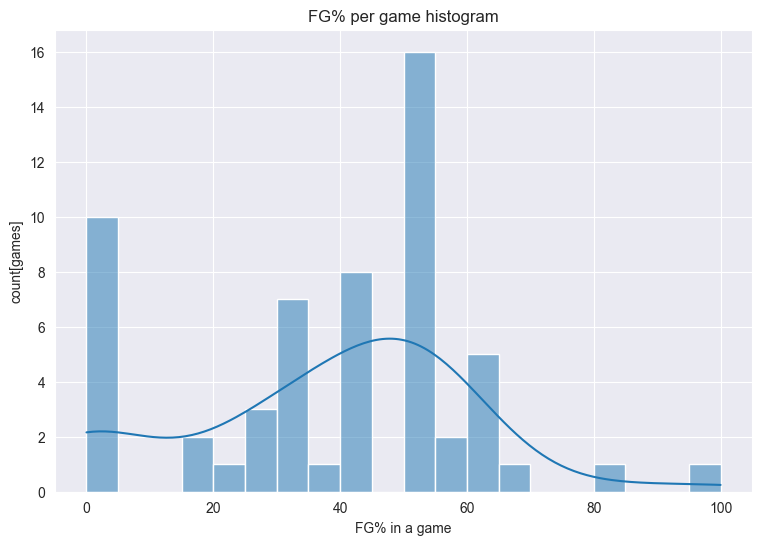

In [77]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_player_games_pd['FGPER'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "FG% per game histogram", xlabel = 'FG% in a game', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

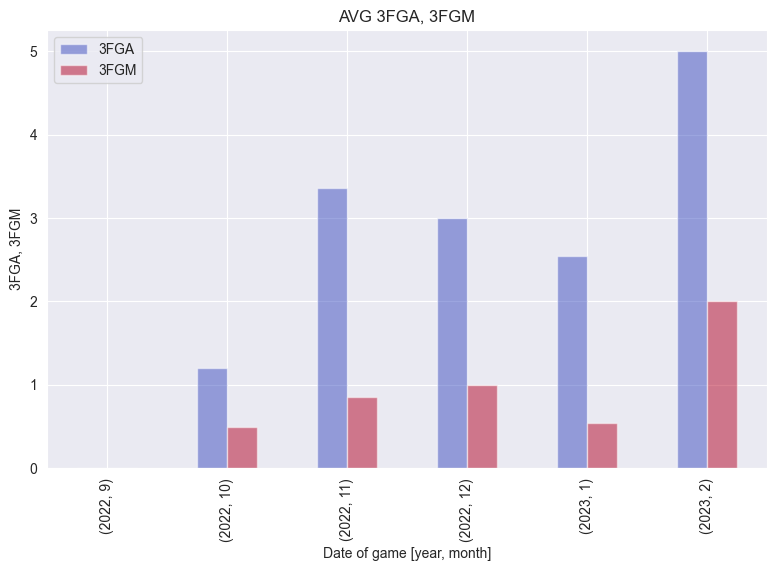

In [78]:
bar_plot = selected_player_games_pd.loc[:, ['ThreePA', 'ThreePM']].groupby([line_plot.index.year, line_plot.index.month]).mean()

fig, ax = plt.subplots(num = figure_count)
figure_count += 1
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.17)
bar_plot.plot(ax = ax, kind='bar', figsize=(9, 6), colormap='coolwarm', alpha = 0.5, legend=['3FGA', '3FGM'])
ax.set_xlabel('Date of game [year, month]')
ax.set_ylabel('3FGA, 3FGM')
ax.set_title('AVG 3FGA, 3FGM')
ax.legend(["3FGA", "3FGM"]);
plt.show(fig);

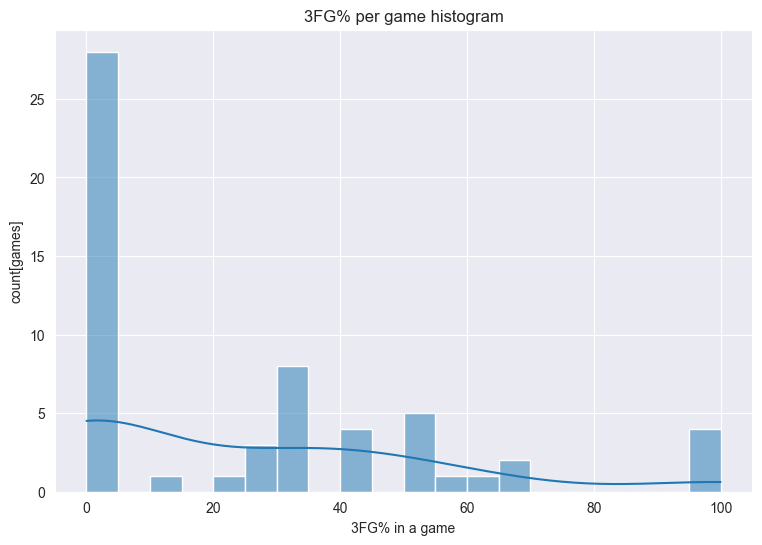

In [79]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_player_games_pd['ThreePPER'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "3FG% per game histogram", xlabel = '3FG% in a game', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

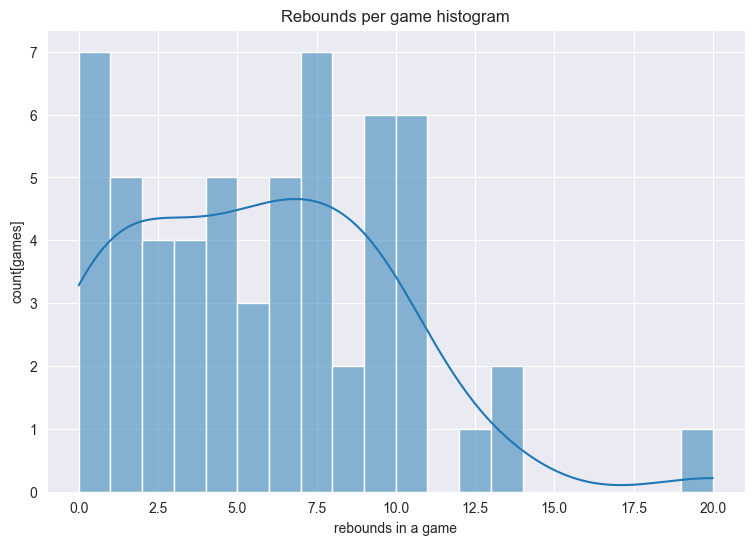

In [80]:
fig = plt.figure(figure_count, figsize = (9, 6))
figure_count += 1
ax = sns.histplot(selected_player_games_pd['REB'].to_numpy(), alpha = 0.5, kde = True, bins = 20)
ax.set(title = "Rebounds per game histogram", xlabel = 'rebounds in a game', ylabel='count[games]')
plt.legend([],[], frameon = False)
plt.show(fig);

## Predict game results
### Dataset creation

In [81]:
prediction_dataset = games.loc[:, ['ID', 'Date', 'HomeTeamID', 'VisitorTeamID']].copy()
prediction_dataset = ps.merge(prediction_dataset, game_team_score[['GameID', 'TeamID', 'PTS']], left_on=['ID', 'HomeTeamID'], right_on=['GameID', 'TeamID']).drop(columns = ['GameID', 'TeamID']).rename(columns={"PTS": "HomeTeamPTS"})
prediction_dataset = ps.merge(prediction_dataset, game_team_score[['GameID', 'TeamID', 'PTS']], left_on=['ID', 'VisitorTeamID'], right_on=['GameID', 'TeamID']).drop(columns = ['GameID', 'TeamID']).rename(columns={"PTS": "VisitorTeamPTS"})
prediction_dataset['HomeTeamWin'] = prediction_dataset['HomeTeamPTS'] > prediction_dataset['VisitorTeamPTS']
prediction_dataset['HomeTeamWin'] = prediction_dataset['HomeTeamWin'].astype(int)
prediction_dataset['VisitorTeamWin'] = prediction_dataset['VisitorTeamPTS'] > prediction_dataset['HomeTeamPTS']
prediction_dataset['VisitorTeamWin'] = prediction_dataset['VisitorTeamWin'].astype(int)

In [82]:
home_team_avg_points_far_list = []
visitor_team_avg_points_so_far_list = []


for i, game in prediction_dataset.iterrows():
    # Home team stats
    pts_home_so_far_df = prediction_dataset.loc[prediction_dataset['HomeTeamID'] == game['HomeTeamID'], :]
    pts_home_so_far_df = pts_home_so_far_df.loc[pts_home_so_far_df['Date'] < game['Date'], :]
    if not pts_home_so_far_df.empty:
        pts_home_so_far = pts_home_so_far_df['HomeTeamPTS'].mean()
    else:
        pts_home_so_far = None

    pts_away_so_far_df = prediction_dataset.loc[prediction_dataset['VisitorTeamID'] == game['HomeTeamID'], :]
    pts_away_so_far_df = pts_away_so_far_df.loc[pts_away_so_far_df['Date'] < game['Date'], :]
    if not pts_away_so_far_df.empty:
        pts_away_so_far = pts_away_so_far_df['VisitorTeamPTS'].mean()
    else:
        pts_away_so_far = None

    if (pts_home_so_far != None) and (pts_away_so_far != None):

        avg_points_so_far = np.mean([pts_home_so_far, pts_away_so_far])
        home_team_avg_points_far_list.append(avg_points_so_far)
    
    elif pts_home_so_far != None:
        home_team_avg_points_far_list.append(pts_home_so_far)

    elif pts_away_so_far != None:
        home_team_avg_points_far_list.append(pts_away_so_far)

    else:
        home_team_avg_points_far_list.append(None)


    # Visitor team stats
    pts_home_so_far_df = prediction_dataset.loc[prediction_dataset['HomeTeamID'] == game['VisitorTeamID'], :]
    pts_home_so_far_df = pts_home_so_far_df.loc[pts_home_so_far_df['Date'] < game['Date'], :]
    if not pts_home_so_far_df.empty:
        pts_home_so_far = pts_home_so_far_df['HomeTeamPTS'].mean()
    else:
        pts_home_so_far = None

    pts_away_so_far_df = prediction_dataset.loc[prediction_dataset['VisitorTeamID'] == game['VisitorTeamID'], :]
    pts_away_so_far_df = pts_away_so_far_df.loc[pts_away_so_far_df['Date'] < game['Date'], :]
    if not pts_away_so_far_df.empty:
        pts_away_so_far = pts_away_so_far_df['VisitorTeamPTS'].mean()
    else:
        pts_away_so_far = None

    if (pts_home_so_far != None) and (pts_away_so_far != None):

        avg_points_so_far = np.mean([pts_home_so_far, pts_away_so_far])
        visitor_team_avg_points_so_far_list.append(avg_points_so_far)
    
    elif pts_home_so_far != None:
        visitor_team_avg_points_so_far_list.append(pts_home_so_far)

    elif pts_away_so_far != None:
        visitor_team_avg_points_so_far_list.append(pts_away_so_far)
        
    else:
        visitor_team_avg_points_so_far_list.append(None)

In [83]:
prediction_dataset['HomeTeamAVGPTS'] = home_team_avg_points_far_list
prediction_dataset['VisitorTeamAVGPTS'] = visitor_team_avg_points_so_far_list

In [84]:
home_team_wins_so_far_list = []
visitor_team_wins_so_far_list = []
home_team_wins_10_last_games = []
visitor_team_wins_10_last_games = []


for i, game in prediction_dataset.iterrows():
    # Home team stats
    wins_home_so_far_df = prediction_dataset.loc[prediction_dataset['HomeTeamID'] == game['HomeTeamID'], :]
    wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['HomeTeamWin'] == 1, :]
    wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['Date'] < game['Date'], :]
    wins_home_so_far = wins_home_so_far_df.shape[0]

    wins_away_so_far_df = prediction_dataset.loc[prediction_dataset['VisitorTeamID'] == game['HomeTeamID'], :]
    wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['VisitorTeamWin'] == 1, :]
    wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['Date'] < game['Date'], :]
    wins_away_so_far = wins_away_so_far_df.shape[0]

    total_games_so_far_df = prediction_dataset.loc[(prediction_dataset['VisitorTeamID'] == game['HomeTeamID']) | (prediction_dataset['HomeTeamID'] == game['HomeTeamID']), :]
    total_games_so_far_df = total_games_so_far_df.loc[total_games_so_far_df['Date'] < game['Date'], :]
    total_games_so_far = total_games_so_far_df.shape[0]

    if total_games_so_far != 0:
        home_team_wins_so_far_list.append((wins_home_so_far + wins_away_so_far) / total_games_so_far)

        if total_games_so_far > 10:
            total_games_so_far_df = total_games_so_far_df.sort_values('Date').iloc[:10, :]

            wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['ID'].isin(total_games_so_far_df['ID'].to_numpy()), :]
            wins_home_so_far = wins_home_so_far_df.shape[0]

            wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['ID'].isin(total_games_so_far_df['ID'].to_numpy()), :]
            wins_away_so_far = wins_away_so_far_df.shape[0]

            total_games_so_far = 10
        home_team_wins_10_last_games.append((wins_home_so_far + wins_away_so_far) / total_games_so_far)
    
    else:
        home_team_wins_so_far_list.append(None)
        home_team_wins_10_last_games.append(None)


    # Visitor team stats
    wins_home_so_far_df = prediction_dataset.loc[prediction_dataset['HomeTeamID'] == game['VisitorTeamID'], :]
    wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['HomeTeamWin'] == 1, :]
    wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['Date'] < game['Date'], :]
    wins_home_so_far = wins_home_so_far_df.shape[0]

    wins_away_so_far_df = prediction_dataset.loc[prediction_dataset['VisitorTeamID'] == game['VisitorTeamID'], :]
    wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['VisitorTeamWin'] == 1, :]
    wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['Date'] < game['Date'], :]
    wins_away_so_far = wins_away_so_far_df.shape[0]

    total_games_so_far_df = prediction_dataset.loc[(prediction_dataset['VisitorTeamID'] == game['VisitorTeamID']) | (prediction_dataset['HomeTeamID'] == game['VisitorTeamID']), :]
    total_games_so_far_df = total_games_so_far_df.loc[total_games_so_far_df['Date'] < game['Date'], :]
    total_games_so_far = total_games_so_far_df.shape[0]

    if total_games_so_far != 0:
        visitor_team_wins_so_far_list.append((wins_home_so_far + wins_away_so_far) / total_games_so_far)

        if total_games_so_far > 10:
            total_games_so_far_df = total_games_so_far_df.sort_values('Date').iloc[:10, :]

            wins_home_so_far_df = wins_home_so_far_df.loc[wins_home_so_far_df['ID'].isin(total_games_so_far_df['ID'].to_numpy()), :]
            wins_home_so_far = wins_home_so_far_df.shape[0]

            wins_away_so_far_df = wins_away_so_far_df.loc[wins_away_so_far_df['ID'].isin(total_games_so_far_df['ID'].to_numpy()), :]
            wins_away_so_far = wins_away_so_far_df.shape[0]

            total_games_so_far = 10
        visitor_team_wins_10_last_games.append((wins_home_so_far + wins_away_so_far) / total_games_so_far)
    else:
        visitor_team_wins_so_far_list.append(None)
        visitor_team_wins_10_last_games.append(None)

In [85]:
prediction_dataset['HomeTeamWins%'] = home_team_wins_so_far_list
prediction_dataset['HomeTeam10GamesWins%'] = home_team_wins_10_last_games
prediction_dataset['VisitorTeamWins%'] = visitor_team_wins_so_far_list
prediction_dataset['VisitorTeam10GamesWins%'] = visitor_team_wins_10_last_games

In [ ]:
prediction_dataset = prediction_dataset.to_spark()

In [111]:
# path = "prediction_dataset/"
# csv_files = glob.glob(os.path.join(path, "*.csv"))
# # loop over the list of csv files
# for f in csv_files:
      
#     # read the csv file
#     prediction_dataset = spark.read.csv(f, inferSchema = True, header = True)

In [112]:
prediction_dataset.columns

['ID',
 'Date',
 'HomeTeamID',
 'VisitorTeamID',
 'HomeTeamPTS',
 'VisitorTeamPTS',
 'HomeTeamWin',
 'VisitorTeamWin',
 'HomeTeamAVGPTS',
 'VisitorTeamAVGPTS',
 'HomeTeamWins%',
 'HomeTeam10GamesWins%',
 'VisitorTeamWins%',
 'VisitorTeam10GamesWins%']

In [113]:
training_columns = ['HomeTeamID', 'VisitorTeamID', 'HomeTeamAVGPTS',
       'VisitorTeamAVGPTS', 'HomeTeamWins%', 'HomeTeam10GamesWins%',
       'VisitorTeamWins%', 'VisitorTeam10GamesWins%']

In [114]:
prediction_dataset.pandas_api().describe()

,ID,Date,HomeTeamID,VisitorTeamID,HomeTeamPTS,VisitorTeamPTS,HomeTeamWin,VisitorTeamWin,HomeTeamAVGPTS,VisitorTeamAVGPTS,HomeTeamWins%,HomeTeam10GamesWins%,VisitorTeamWins%,VisitorTeam10GamesWins%
count,9.090000e+02,909,9.090000e+02,9.090000e+02,909.000000,909.000000,909.000000,909.000000,896.000000,892.000000,896.000000,896.000000,892.000000,892.000000
mean,2.148532e+07,2022-12-10 13:34:55.049505,1.610613e+09,1.610613e+09,115.000000,112.000000,0.000000,0.000000,112.300849,112.395842,0.502222,0.508899,0.502903,0.504145
min,1.220000e+07,2022-09-30 00:00:00,1.610613e+09,1.610613e+09,75.000000,81.000000,0.000000,0.000000,75.000000,82.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220016e+07,2022-11-10 00:00:00,1.610613e+09,1.610613e+09,107.000000,105.000000,0.000000,0.000000,109.881016,109.945926,0.435897,0.400000,0.437500,0.400000
50%,2.220039e+07,2022-12-11 00:00:00,1.610613e+09,1.610613e+09,115.000000,112.000000,1.000000,0.000000,112.613527,112.709091,0.520000,0.600000,0.520000,0.600000
75%,2.220062e+07,2023-01-11 00:00:00,1.610613e+09,1.610613e+09,123.000000,120.000000,1.000000,1.000000,115.195106,115.237200,0.600000,0.600000,0.600000,0.600000
max,2.220084e+07,2023-02-11 00:00:00,1.610613e+09,1.610613e+09,153.000000,150.000000,1.000000,1.000000,134.000000,128.000000,1.000000,1.000000,1.000000,1.000000
std,2.578219e+06,None,8.568579e+00,8.740938e+00,11.869975,11.315678,0.493509,0.493509,4.587175,4.505979,0.164892,0.189106,0.164244,0.190536


In [115]:
prediction_dataset = prediction_dataset.fillna(-1)

In [116]:
assembler = VectorAssembler(inputCols=training_columns, outputCol='features', handleInvalid="keep")
bdp_train_assembler = assembler.transform(prediction_dataset).select('features', 'HomeTeamWin')

In [117]:
bdp_train_assembler.show()

+--------------------+-----------+
|            features|HomeTeamWin|
+--------------------+-----------+
|[1.610612744E9,1....|          0|
|[1.610612753E9,1....|          0|
|[1.610612745E9,1....|          0|
|[1.610612748E9,1....|          1|
|[1.610612748E9,1....|          1|
|[1.610612739E9,1....|          1|
|[1.61061276E9,1.6...|          1|
|[1.610612741E9,1....|          0|
|[1.610612755E9,1....|          1|
|[1.61061274E9,1.6...|          1|
|[1.610612763E9,1....|          1|
|[1.610612763E9,1....|          1|
|[1.610612759E9,1....|          0|
|[1.610612761E9,1....|          1|
|[1.610612737E9,1....|          1|
|[1.610612757E9,1....|          1|
|[1.610612762E9,1....|          0|
|[1.610612742E9,1....|          1|
|[1.610612753E9,1....|          1|
|[1.610612745E9,1....|          0|
+--------------------+-----------+
only showing top 20 rows



In [118]:
scaler = MinMaxScaler(min=0., max=1., inputCol="features", outputCol="scaledFeatures")

# Normalize the data
scaledData = scaler.fit(bdp_train_assembler).transform(bdp_train_assembler)

scaledData.show(5)


+--------------------+-----------+--------------------+
|            features|HomeTeamWin|      scaledFeatures|
+--------------------+-----------+--------------------+
|[1.610612744E9,1....|          0|[0.24137931034482...|
|[1.610612753E9,1....|          0|[0.55172413793103...|
|[1.610612745E9,1....|          0|[0.27586206896551...|
|[1.610612748E9,1....|          1|[0.37931034482758...|
|[1.610612748E9,1....|          1|[0.37931034482758...|
+--------------------+-----------+--------------------+
only showing top 5 rows



In [119]:
train_data, val_data = scaledData.randomSplit([0.8, 0.2])

In [140]:
def print_result(classifier,scores,results_df):
    # extract params and use it as the base for ditionary rsults
    dict_res = {'Classifier' : classifier}

    # recall
    dict_res['Train score'] = np.mean(scores[0]) * 100
    dict_res['Val score'] = np.mean(scores[1]) * 100
    
    # print results
    print(f"Classifier: {dict_res['Classifier']}")
    print(f"Train score: {np.round(dict_res['Train score'],2)}, Validation score {np.round(dict_res['Val score'],2)}")
    
    results_df = results_df.append(dict_res, ignore_index=True)

    return results_df

In [141]:
results_df = pd.DataFrame()

In [142]:
# In use for all models
binary_eval = BinaryClassificationEvaluator(labelCol='HomeTeamWin')
evaluator = BinaryClassificationEvaluator()

In [143]:
from pyspark.ml.classification import LogisticRegression

linear_reg = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin')

LR_model = linear_reg.fit(train_data)

lr_preds = LR_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = LR_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Logistic Regression',[train_score, val_score],results_df)

Classifier: Logistic Regression
Train score: 60.78, Validation score 56.98


In [144]:
from pyspark.ml.classification import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin')

DT_model = decision_tree.fit(train_data)

lr_preds = DT_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = DT_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Decision Tree',[train_score, val_score],results_df)

Classifier: Decision Tree
Train score: 57.11, Validation score 44.78


In [145]:
from pyspark.ml.classification import RandomForestClassifier

random_forest = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin')

RF_model = random_forest.fit(train_data)

lr_preds = RF_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = RF_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Random Forest',[train_score, val_score],results_df)

Classifier: Random Forest
Train score: 85.58, Validation score 55.15


In [146]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin')

GBT_model = gbt.fit(train_data)

lr_preds = GBT_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = GBT_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Gradient Boosted Trees',[train_score, val_score],results_df)

Classifier: Gradient Boosted Trees
Train score: 98.71, Validation score 56.77


In [147]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

perceptron = MultilayerPerceptronClassifier(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin', layers=[len(training_columns), 4, 2])

MLP_model = perceptron.fit(train_data)

lr_preds = MLP_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = MLP_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Multi Layer Perceptron',[train_score, val_score],results_df)

Classifier: Multi Layer Perceptron
Train score: 62.88, Validation score 54.74


In [148]:
from pyspark.ml.classification import NaiveBayes

naive_bayes = NaiveBayes(featuresCol = 'scaledFeatures', labelCol = 'HomeTeamWin')

NB_model = naive_bayes.fit(train_data)

lr_preds = NB_model.transform(train_data)

train_score = binary_eval.evaluate(lr_preds)

lr_preds = NB_model.transform(val_data)

val_score = binary_eval.evaluate(lr_preds)

results_df = print_result('Naive Bayes',[train_score, val_score],results_df)

Classifier: Naive Bayes
Train score: 52.64, Validation score 51.45


In [149]:
results_df

,Classifier,Train score,Val score
0,Logistic Regression,60.776707,56.980057
1,Decision Tree,57.107220,44.782764
2,Random Forest,85.581350,55.151947
3,Gradient Boosted Trees,98.712965,56.766382
4,Multi Layer Perceptron,62.882550,54.736467
5,Naive Bayes,52.640567,51.448243
